# Predict #
To be re-inserted into main Jupyter Notebook after.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For neural networks.
import keras as kr
# For data frames.
import pandas as pd
# For numerical arrays.
import numpy as np
# For preprocessing data.
import sklearn.preprocessing as pre
# For splitting data sets.
import sklearn.model_selection as mod
# For whitening.
import sklearn.decomposition as dec
# to write to csv file
import csv

Using TensorFlow backend.


In [2]:
# Import sklearn for comparison too
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset into a dataframe
data = pd.DataFrame(data = load_boston().data, columns= load_boston().feature_names)
# Add the house price
data["MEDV"] = load_boston().target
# Quick check that all is ok
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


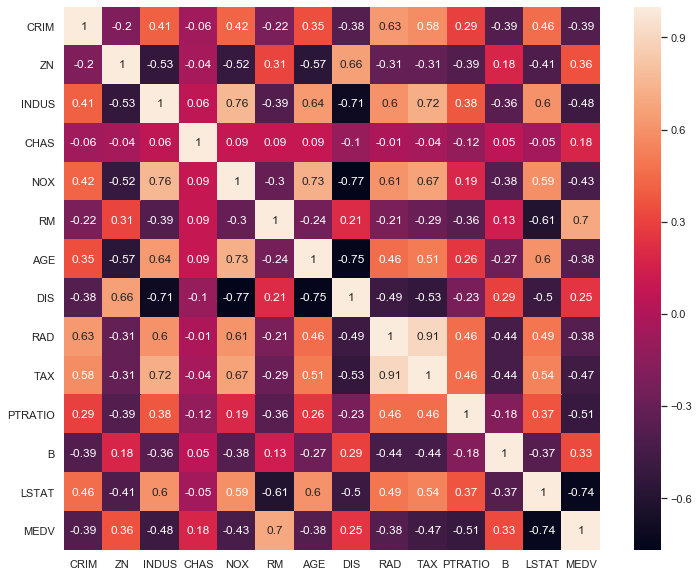

In [4]:
sns.set(rc={'figure.figsize':(12,10)})
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
correlation_matrix["MEDV"]

CRIM      -0.39
ZN         0.36
INDUS     -0.48
CHAS       0.18
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
B          0.33
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [6]:
cm = correlation_matrix.transform(func= lambda x: abs(x))["MEDV"].sort_values(ascending=False)
cm = cm.drop("MEDV",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
RAD        0.38
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

Because the TAX and RAD parameters are highly correlated (0.91) both should not be  used in training any model. As TAX has a higher correlation than RAD, the RAD feature will be dropped.

In [7]:
cm = cm.drop("RAD",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

In [8]:
# Putting all possible parameters in a list in order of correlation
params = []
for i in range(0, len(cm)):
    params.append(cm.index[i])

In [9]:
y = data['MEDV'] # outputs

def getInputs(noPar):
    # Split the dataset into what we are using
    return data[params[:noPar]] # inputs

In [10]:
def scaleDS(inputs):
    # Adding a scaler
    scaler = pre.StandardScaler()
    scaler.fit(inputs)
    return scaler.transform(inputs)

In [11]:
def splitDS(inputs):
    global x_train, x_test, y_train, y_test
    # Split the dataset into training and testing
    x_train, x_test, y_train, y_test = mod.train_test_split(inputs, y, test_size=testSize)

In [12]:
def createModel(actType, optType):
    global noParams, noEpoch, batchSize
    # Create our model
    m = kr.models.Sequential()
    m.add(kr.layers.Dense(20, input_dim=noParams, activation = actType))
    m.add(kr.layers.Dense(1, activation="linear"))
    m.compile(loss = "mean_squared_error", optimizer =optType)
    # Train the network
    m.fit(x_train, y_train, epochs=noEpoch, batch_size=batchSize)
    return m

In [13]:
def doModel(model, epo, bs):
    global x_trian, x_test, y_tran, y_test, batchSize
    # Train the network
    model.fit(x_train, y_train, epochs=epo, batch_size=bs)
    # Calculate the loss function (Mean squared error in our case)
    return model.evaluate(x_test, y_test)

In [14]:
# Headings for the data
results= []

In [34]:
# Parameterise everything

# Do you want to create and test all the models? 
# If yes, set the following to true, if no, leave at false and data from previous run will be read into dataframe
yesCreateModels = True

# No of variables to include in predictions
noParams = 4 

# Test / Train Split
testSize = 0.3

# All the activations
acts = ["relu", "tanh", "sigmoid", "exponential", "elu", "linear"]
#act = acts[5]

# Optimisers
opts= ["sgd", "adam", "nadam"]
opt = opts[1]

# model trial settings
noEpoch= 100
batchSize = 10

# Whether the data should be scaled or not
scaling = True

if yesCreateModels == True:
    # Check for increasing no of attributes and all activations
    for act in acts:
        for noParams in range(1,12):
            # Create your inputs
            x = getInputs(noParams)
            # Scale if it is called for
            if scaling  == True:
                x_scaled = scaleDS(x)
            else:
                x_scaled = x
            # Split into training and testing data
            splitDS(x_scaled)
            # Create the model based on the paramters supplied
            m = createModel(act, opt)
            # Append the settings and final loss results after fitting and evaluating the model to the results file
            results.append([noParams, scaling, testSize, act, opt, noEpoch, batchSize, doModel(m, noEpoch, batchSize)])

Epoch 1/100
354/354 [==============================] - 0s 531us/step - loss: 569.7050
Epoch 2/100
354/354 [==============================] - 0s 96us/step - loss: 556.0194
Epoch 3/100
354/354 [==============================] - 0s 101us/step - loss: 540.7239
Epoch 4/100
354/354 [==============================] - 0s 93us/step - loss: 523.1200
Epoch 5/100
354/354 [==============================] - 0s 121us/step - loss: 502.5718
Epoch 6/100
354/354 [==============================] - 0s 82us/step - loss: 479.2957
Epoch 7/100
354/354 [==============================] - 0s 104us/step - loss: 453.1825
Epoch 8/100
354/354 [==============================] - 0s 82us/step - loss: 424.9382
Epoch 9/100
354/354 [==============================] - 0s 99us/step - loss: 394.9379
Epoch 10/100
354/354 [==============================] - 0s 79us/step - loss: 363.5242
Epoch 11/100
354/354 [==============================] - 0s 93us/step - loss: 331.1177
Epoch 12/100
354/354 [==============================] - 0s 

354/354 [==============================] - 0s 82us/step - loss: 34.0083
Epoch 97/100
354/354 [==============================] - 0s 79us/step - loss: 34.0426
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 33.9685
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 34.0107
Epoch 100/100
354/354 [==============================] - 0s 73us/step - loss: 33.9940
Epoch 1/100
354/354 [==============================] - 0s 73us/step - loss: 33.9031
Epoch 2/100
354/354 [==============================] - 0s 82us/step - loss: 33.9152
Epoch 3/100
354/354 [==============================] - 0s 87us/step - loss: 33.8952
Epoch 4/100
354/354 [==============================] - 0s 82us/step - loss: 33.8538
Epoch 5/100
354/354 [==============================] - 0s 107us/step - loss: 33.8487
Epoch 6/100
354/354 [==============================] - 0s 99us/step - loss: 33.7908
Epoch 7/100
354/354 [==============================] - 0s 93us/step - loss: 33.784

354/354 [==============================] - 0s 82us/step - loss: 32.4082
Epoch 93/100
354/354 [==============================] - 0s 82us/step - loss: 32.3051
Epoch 94/100
354/354 [==============================] - 0s 76us/step - loss: 32.3209
Epoch 95/100
354/354 [==============================] - 0s 107us/step - loss: 32.4687
Epoch 96/100
354/354 [==============================] - 0s 70us/step - loss: 32.3021
Epoch 97/100
354/354 [==============================] - 0s 87us/step - loss: 32.2683
Epoch 98/100
354/354 [==============================] - 0s 93us/step - loss: 32.2643
Epoch 99/100
354/354 [==============================] - 0s 96us/step - loss: 32.2491
Epoch 100/100
152/152 [==============================] - 0s 144us/step
Epoch 1/100
354/354 [==============================] - 0s 551us/step - loss: 588.8061
Epoch 2/100
354/354 [==============================] - 0s 101us/step - loss: 574.5569
Epoch 3/100
354/354 [==============================] - 0s 92us/step - loss: 559.1028
Epoc

354/354 [==============================] - 0s 118us/step - loss: 21.9031
Epoch 88/100
354/354 [==============================] - 0s 103us/step - loss: 21.8828
Epoch 89/100
354/354 [==============================] - 0s 99us/step - loss: 21.8524
Epoch 90/100
354/354 [==============================] - 0s 104us/step - loss: 21.8484
Epoch 91/100
354/354 [==============================] - 0s 107us/step - loss: 21.7911
Epoch 92/100
354/354 [==============================] - 0s 93us/step - loss: 21.7211
Epoch 93/100
354/354 [==============================] - 0s 104us/step - loss: 21.7435
Epoch 94/100
354/354 [==============================] - 0s 104us/step - loss: 21.6679
Epoch 95/100
354/354 [==============================] - 0s 132us/step - loss: 21.6156
Epoch 96/100
354/354 [==============================] - 0s 104us/step - loss: 21.6241
Epoch 97/100
354/354 [==============================] - 0s 101us/step - loss: 21.5796
Epoch 98/100
354/354 [==============================] - 0s 99us/step 

354/354 [==============================] - 0s 99us/step - loss: 20.0491
Epoch 83/100
354/354 [==============================] - 0s 101us/step - loss: 20.0614
Epoch 84/100
354/354 [==============================] - 0s 93us/step - loss: 20.0432
Epoch 85/100
354/354 [==============================] - 0s 113us/step - loss: 20.0997
Epoch 86/100
354/354 [==============================] - 0s 93us/step - loss: 20.0563
Epoch 87/100
354/354 [==============================] - 0s 93us/step - loss: 20.0710
Epoch 88/100
354/354 [==============================] - 0s 104us/step - loss: 20.0786
Epoch 89/100
354/354 [==============================] - 0s 99us/step - loss: 20.0094
Epoch 90/100
354/354 [==============================] - 0s 90us/step - loss: 19.9755
Epoch 91/100
354/354 [==============================] - 0s 121us/step - loss: 19.9878
Epoch 92/100
354/354 [==============================] - 0s 169us/step - loss: 19.9840
Epoch 93/100
354/354 [==============================] - 0s 144us/step - l

354/354 [==============================] - 0s 110us/step - loss: 19.6938
Epoch 78/100
354/354 [==============================] - 0s 132us/step - loss: 19.5936
Epoch 79/100
354/354 [==============================] - 0s 116us/step - loss: 19.4852
Epoch 80/100
354/354 [==============================] - 0s 124us/step - loss: 19.3722
Epoch 81/100
354/354 [==============================] - 0s 166us/step - loss: 19.3042
Epoch 82/100
354/354 [==============================] - 0s 101us/step - loss: 19.2235
Epoch 83/100
354/354 [==============================] - 0s 112us/step - loss: 19.1347
Epoch 84/100
354/354 [==============================] - 0s 99us/step - loss: 19.0535
Epoch 85/100
354/354 [==============================] - 0s 121us/step - loss: 18.9557
Epoch 86/100
354/354 [==============================] - 0s 107us/step - loss: 18.8848
Epoch 87/100
354/354 [==============================] - 0s 113us/step - loss: 18.8208
Epoch 88/100
354/354 [==============================] - 0s 116us/ste

354/354 [==============================] - 0s 132us/step - loss: 15.5043
Epoch 73/100
354/354 [==============================] - 0s 127us/step - loss: 15.4616
Epoch 74/100
354/354 [==============================] - 0s 107us/step - loss: 15.4499
Epoch 75/100
354/354 [==============================] - 0s 124us/step - loss: 15.4055
Epoch 76/100
354/354 [==============================] - 0s 113us/step - loss: 15.3844
Epoch 77/100
354/354 [==============================] - 0s 99us/step - loss: 15.3719
Epoch 78/100
354/354 [==============================] - 0s 217us/step - loss: 15.4378
Epoch 79/100
354/354 [==============================] - 0s 205us/step - loss: 15.3285
Epoch 80/100
354/354 [==============================] - 0s 186us/step - loss: 15.3005
Epoch 81/100
354/354 [==============================] - 0s 163us/step - loss: 15.2972
Epoch 82/100
354/354 [==============================] - 0s 116us/step - loss: 15.2680
Epoch 83/100
354/354 [==============================] - 0s 130us/ste

354/354 [==============================] - 0s 99us/step - loss: 20.6021
Epoch 67/100
354/354 [==============================] - 0s 96us/step - loss: 20.3767
Epoch 68/100
354/354 [==============================] - 0s 95us/step - loss: 20.1969
Epoch 69/100
354/354 [==============================] - 0s 99us/step - loss: 20.0361
Epoch 70/100
354/354 [==============================] - 0s 96us/step - loss: 19.8204
Epoch 71/100
354/354 [==============================] - 0s 99us/step - loss: 19.6677
Epoch 72/100
354/354 [==============================] - 0s 90us/step - loss: 19.4688
Epoch 73/100
354/354 [==============================] - 0s 96us/step - loss: 19.3185
Epoch 74/100
354/354 [==============================] - 0s 104us/step - loss: 19.1249
Epoch 75/100
354/354 [==============================] - 0s 90us/step - loss: 18.9774
Epoch 76/100
354/354 [==============================] - 0s 87us/step - loss: 18.8442
Epoch 77/100
354/354 [==============================] - 0s 99us/step - loss: 

Epoch 62/100
354/354 [==============================] - 0s 118us/step - loss: 14.6974
Epoch 63/100
354/354 [==============================] - 0s 124us/step - loss: 14.6749
Epoch 64/100
354/354 [==============================] - 0s 110us/step - loss: 14.6812
Epoch 65/100
354/354 [==============================] - 0s 113us/step - loss: 14.6593
Epoch 66/100
354/354 [==============================] - 0s 101us/step - loss: 14.5944
Epoch 67/100
354/354 [==============================] - 0s 104us/step - loss: 14.5982
Epoch 68/100
354/354 [==============================] - 0s 99us/step - loss: 14.5352
Epoch 69/100
354/354 [==============================] - 0s 113us/step - loss: 14.4937
Epoch 70/100
354/354 [==============================] - 0s 110us/step - loss: 14.4907
Epoch 71/100
354/354 [==============================] - 0s 107us/step - loss: 14.4470
Epoch 72/100
354/354 [==============================] - 0s 135us/step - loss: 14.4598
Epoch 73/100
354/354 [==============================] -

354/354 [==============================] - 0s 118us/step - loss: 21.4442
Epoch 57/100
354/354 [==============================] - 0s 132us/step - loss: 21.1276
Epoch 58/100
354/354 [==============================] - 0s 130us/step - loss: 20.8548
Epoch 59/100
354/354 [==============================] - 0s 116us/step - loss: 20.5392
Epoch 60/100
354/354 [==============================] - 0s 110us/step - loss: 20.2865
Epoch 61/100
354/354 [==============================] - 0s 135us/step - loss: 20.0141
Epoch 62/100
354/354 [==============================] - 0s 124us/step - loss: 19.7667
Epoch 63/100
354/354 [==============================] - 0s 177us/step - loss: 19.5673
Epoch 64/100
354/354 [==============================] - 0s 183us/step - loss: 19.2982
Epoch 65/100
354/354 [==============================] - 0s 128us/step - loss: 19.0590
Epoch 66/100
354/354 [==============================] - 0s 124us/step - loss: 18.8720
Epoch 67/100
354/354 [==============================] - 0s 124us/st

354/354 [==============================] - 0s 113us/step - loss: 13.4434
Epoch 52/100
354/354 [==============================] - 0s 110us/step - loss: 13.3089
Epoch 53/100
354/354 [==============================] - 0s 97us/step - loss: 13.3085
Epoch 54/100
354/354 [==============================] - 0s 96us/step - loss: 13.3327
Epoch 55/100
354/354 [==============================] - 0s 107us/step - loss: 13.2820
Epoch 56/100
354/354 [==============================] - 0s 116us/step - loss: 13.2763
Epoch 57/100
354/354 [==============================] - 0s 149us/step - loss: 13.2698
Epoch 58/100
354/354 [==============================] - 0s 166us/step - loss: 13.2265
Epoch 59/100
354/354 [==============================] - 0s 133us/step - loss: 13.2114
Epoch 60/100
354/354 [==============================] - 0s 101us/step - loss: 13.2064
Epoch 61/100
354/354 [==============================] - 0s 96us/step - loss: 13.2320
Epoch 62/100
354/354 [==============================] - 0s 87us/step -

354/354 [==============================] - 0s 124us/step - loss: 38.6041
Epoch 47/100
354/354 [==============================] - 0s 96us/step - loss: 37.6167
Epoch 48/100
354/354 [==============================] - 0s 99us/step - loss: 36.5389
Epoch 49/100
354/354 [==============================] - 0s 87us/step - loss: 35.5928
Epoch 50/100
354/354 [==============================] - 0s 96us/step - loss: 34.6106
Epoch 51/100
354/354 [==============================] - 0s 104us/step - loss: 33.6804
Epoch 52/100
354/354 [==============================] - 0s 90us/step - loss: 32.8935
Epoch 53/100
354/354 [==============================] - 0s 101us/step - loss: 31.9821
Epoch 54/100
354/354 [==============================] - 0s 107us/step - loss: 31.2355
Epoch 55/100
354/354 [==============================] - 0s 82us/step - loss: 30.4984
Epoch 56/100
354/354 [==============================] - 0s 80us/step - loss: 29.7670
Epoch 57/100
354/354 [==============================] - 0s 99us/step - los

354/354 [==============================] - 0s 76us/step - loss: 15.7316
Epoch 43/100
354/354 [==============================] - 0s 96us/step - loss: 15.7639
Epoch 44/100
354/354 [==============================] - 0s 90us/step - loss: 15.6425
Epoch 45/100
354/354 [==============================] - 0s 85us/step - loss: 15.6213
Epoch 46/100
354/354 [==============================] - 0s 82us/step - loss: 15.5669
Epoch 47/100
354/354 [==============================] - 0s 85us/step - loss: 15.5784
Epoch 48/100
354/354 [==============================] - 0s 87us/step - loss: 15.5161
Epoch 49/100
354/354 [==============================] - 0s 70us/step - loss: 15.5028
Epoch 50/100
354/354 [==============================] - 0s 79us/step - loss: 15.5432
Epoch 51/100
354/354 [==============================] - 0s 73us/step - loss: 15.4620
Epoch 52/100
354/354 [==============================] - 0s 79us/step - loss: 15.4335
Epoch 53/100
354/354 [==============================] - 0s 73us/step - loss: 1

354/354 [==============================] - 0s 93us/step - loss: 31.4198
Epoch 38/100
354/354 [==============================] - 0s 93us/step - loss: 30.4418
Epoch 39/100
354/354 [==============================] - 0s 87us/step - loss: 29.5449
Epoch 40/100
354/354 [==============================] - 0s 82us/step - loss: 28.7226
Epoch 41/100
354/354 [==============================] - 0s 90us/step - loss: 27.9491
Epoch 42/100
354/354 [==============================] - 0s 85us/step - loss: 27.2441
Epoch 43/100
354/354 [==============================] - 0s 90us/step - loss: 26.5118
Epoch 44/100
354/354 [==============================] - 0s 107us/step - loss: 25.8880
Epoch 45/100
354/354 [==============================] - 0s 85us/step - loss: 25.2885
Epoch 46/100
354/354 [==============================] - 0s 73us/step - loss: 24.7147
Epoch 47/100
354/354 [==============================] - 0s 79us/step - loss: 24.2727
Epoch 48/100
354/354 [==============================] - 0s 82us/step - loss: 

354/354 [==============================] - 0s 107us/step - loss: 13.4728
Epoch 34/100
354/354 [==============================] - 0s 93us/step - loss: 13.4857
Epoch 35/100
354/354 [==============================] - 0s 82us/step - loss: 13.4683
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 13.4469
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 13.4301
Epoch 38/100
354/354 [==============================] - 0s 85us/step - loss: 13.4273
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: 13.3611
Epoch 40/100
354/354 [==============================] - 0s 86us/step - loss: 13.3549
Epoch 41/100
354/354 [==============================] - 0s 87us/step - loss: 13.2850
Epoch 42/100
354/354 [==============================] - 0s 121us/step - loss: 13.2717
Epoch 43/100
354/354 [==============================] - 0s 81us/step - loss: 13.2869
Epoch 44/100
354/354 [==============================] - 0s 79us/step - loss:

354/354 [==============================] - 0s 90us/step - loss: 39.7957
Epoch 29/100
354/354 [==============================] - 0s 87us/step - loss: 38.3668
Epoch 30/100
354/354 [==============================] - 0s 87us/step - loss: 36.8350
Epoch 31/100
354/354 [==============================] - 0s 90us/step - loss: 35.5472
Epoch 32/100
354/354 [==============================] - 0s 96us/step - loss: 34.2480
Epoch 33/100
354/354 [==============================] - 0s 87us/step - loss: 33.1760
Epoch 34/100
354/354 [==============================] - 0s 96us/step - loss: 32.1041
Epoch 35/100
354/354 [==============================] - 0s 96us/step - loss: 31.0931
Epoch 36/100
354/354 [==============================] - 0s 82us/step - loss: 30.1975
Epoch 37/100
354/354 [==============================] - 0s 90us/step - loss: 29.3229
Epoch 38/100
354/354 [==============================] - 0s 96us/step - loss: 28.5604
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: 2

354/354 [==============================] - 0s 93us/step - loss: 13.1560
Epoch 25/100
354/354 [==============================] - 0s 93us/step - loss: 13.1327
Epoch 26/100
354/354 [==============================] - 0s 82us/step - loss: 13.0897
Epoch 27/100
354/354 [==============================] - 0s 96us/step - loss: 13.0100
Epoch 28/100
354/354 [==============================] - 0s 82us/step - loss: 12.9996
Epoch 29/100
354/354 [==============================] - 0s 90us/step - loss: 12.9706
Epoch 30/100
354/354 [==============================] - 0s 85us/step - loss: 12.9198
Epoch 31/100
354/354 [==============================] - 0s 87us/step - loss: 12.9118
Epoch 32/100
354/354 [==============================] - 0s 93us/step - loss: 12.8513
Epoch 33/100
354/354 [==============================] - 0s 90us/step - loss: 12.8502
Epoch 34/100
354/354 [==============================] - 0s 99us/step - loss: 12.7474
Epoch 35/100
354/354 [==============================] - 0s 90us/step - loss: 1

354/354 [==============================] - 0s 87us/step - loss: 81.2276
Epoch 20/100
354/354 [==============================] - 0s 84us/step - loss: 71.7959
Epoch 21/100
354/354 [==============================] - 0s 96us/step - loss: 63.9313
Epoch 22/100
354/354 [==============================] - 0s 82us/step - loss: 57.6496
Epoch 23/100
354/354 [==============================] - 0s 82us/step - loss: 52.3431
Epoch 24/100
354/354 [==============================] - 0s 79us/step - loss: 47.8323
Epoch 25/100
354/354 [==============================] - 0s 93us/step - loss: 44.2906
Epoch 26/100
354/354 [==============================] - 0s 90us/step - loss: 40.9596
Epoch 27/100
354/354 [==============================] - 0s 87us/step - loss: 38.3456
Epoch 28/100
354/354 [==============================] - 0s 96us/step - loss: 36.0716
Epoch 29/100
354/354 [==============================] - 0s 104us/step - loss: 34.2770
Epoch 30/100
354/354 [==============================] - 0s 93us/step - loss: 

354/354 [==============================] - 0s 96us/step - loss: 15.6809
Epoch 16/100
354/354 [==============================] - 0s 93us/step - loss: 15.6753
Epoch 17/100
354/354 [==============================] - 0s 99us/step - loss: 15.5524
Epoch 18/100
354/354 [==============================] - 0s 87us/step - loss: 15.5300
Epoch 19/100
354/354 [==============================] - 0s 116us/step - loss: 15.4498
Epoch 20/100
354/354 [==============================] - 0s 99us/step - loss: 15.4818
Epoch 21/100
354/354 [==============================] - 0s 93us/step - loss: 15.3830
Epoch 22/100
354/354 [==============================] - 0s 99us/step - loss: 15.3106
Epoch 23/100
354/354 [==============================] - 0s 99us/step - loss: 15.2942
Epoch 24/100
354/354 [==============================] - 0s 110us/step - loss: 15.2658
Epoch 25/100
354/354 [==============================] - 0s 99us/step - loss: 15.1799
Epoch 26/100
354/354 [==============================] - 0s 93us/step - loss:

354/354 [==============================] - 0s 116us/step - loss: 271.9314
Epoch 11/100
354/354 [==============================] - 0s 96us/step - loss: 228.6208
Epoch 12/100
354/354 [==============================] - 0s 96us/step - loss: 188.7079
Epoch 13/100
354/354 [==============================] - 0s 76us/step - loss: 153.6596
Epoch 14/100
354/354 [==============================] - 0s 82us/step - loss: 125.2982
Epoch 15/100
354/354 [==============================] - 0s 87us/step - loss: 102.5595
Epoch 16/100
354/354 [==============================] - 0s 87us/step - loss: 85.7223
Epoch 17/100
354/354 [==============================] - 0s 87us/step - loss: 73.0233
Epoch 18/100
354/354 [==============================] - 0s 76us/step - loss: 63.9890
Epoch 19/100
354/354 [==============================] - 0s 85us/step - loss: 57.0525
Epoch 20/100
354/354 [==============================] - 0s 89us/step - loss: 51.8570
Epoch 21/100
354/354 [==============================] - 0s 87us/step - 

354/354 [==============================] - 0s 85us/step - loss: 15.7313
Epoch 7/100
354/354 [==============================] - 0s 76us/step - loss: 15.6374
Epoch 8/100
354/354 [==============================] - 0s 85us/step - loss: 15.5423
Epoch 9/100
354/354 [==============================] - 0s 85us/step - loss: 15.5131
Epoch 10/100
354/354 [==============================] - 0s 87us/step - loss: 15.3183
Epoch 11/100
354/354 [==============================] - 0s 76us/step - loss: 15.2375
Epoch 12/100
354/354 [==============================] - 0s 79us/step - loss: 15.1150
Epoch 13/100
354/354 [==============================] - 0s 87us/step - loss: 15.0755
Epoch 14/100
354/354 [==============================] - 0s 85us/step - loss: 14.9890
Epoch 15/100
354/354 [==============================] - 0s 87us/step - loss: 14.9268
Epoch 16/100
354/354 [==============================] - 0s 82us/step - loss: 14.8153
Epoch 17/100
354/354 [==============================] - 0s 99us/step - loss: 14.7

354/354 [==============================] - 0s 645us/step - loss: 554.1781
Epoch 2/100
354/354 [==============================] - 0s 96us/step - loss: 520.5563
Epoch 3/100
354/354 [==============================] - 0s 110us/step - loss: 484.7421
Epoch 4/100
354/354 [==============================] - 0s 96us/step - loss: 446.0565
Epoch 5/100
354/354 [==============================] - 0s 107us/step - loss: 405.7676
Epoch 6/100
354/354 [==============================] - 0s 99us/step - loss: 363.7004
Epoch 7/100
354/354 [==============================] - 0s 104us/step - loss: 321.1881
Epoch 8/100
354/354 [==============================] - 0s 96us/step - loss: 280.1666
Epoch 9/100
354/354 [==============================] - 0s 96us/step - loss: 240.1564
Epoch 10/100
354/354 [==============================] - 0s 104us/step - loss: 204.2468
Epoch 11/100
354/354 [==============================] - 0s 99us/step - loss: 172.2378
Epoch 12/100
354/354 [==============================] - 0s 93us/step -

354/354 [==============================] - 0s 116us/step - loss: 12.7587
Epoch 97/100
354/354 [==============================] - 0s 104us/step - loss: 12.6073
Epoch 98/100
354/354 [==============================] - 0s 96us/step - loss: 12.4967
Epoch 99/100
354/354 [==============================] - 0s 110us/step - loss: 12.4706
Epoch 100/100
354/354 [==============================] - 0s 124us/step - loss: 12.3144
Epoch 1/100
354/354 [==============================] - 0s 101us/step - loss: 12.2357
Epoch 2/100
354/354 [==============================] - 0s 107us/step - loss: 12.1332
Epoch 3/100
354/354 [==============================] - 0s 121us/step - loss: 12.0476
Epoch 4/100
354/354 [==============================] - 0s 99us/step - loss: 11.9588
Epoch 5/100
354/354 [==============================] - 0s 101us/step - loss: 11.8632
Epoch 6/100
354/354 [==============================] - 0s 101us/step - loss: 11.7944
Epoch 7/100
354/354 [==============================] - 0s 96us/step - loss

354/354 [==============================] - 0s 99us/step - loss: 8.8909
Epoch 93/100
354/354 [==============================] - 0s 104us/step - loss: 8.9339
Epoch 94/100
354/354 [==============================] - 0s 110us/step - loss: 8.8082
Epoch 95/100
354/354 [==============================] - 0s 101us/step - loss: 8.8518
Epoch 96/100
354/354 [==============================] - 0s 93us/step - loss: 8.7844
Epoch 97/100
354/354 [==============================] - 0s 104us/step - loss: 8.8048
Epoch 98/100
354/354 [==============================] - 0s 107us/step - loss: 8.7873
Epoch 99/100
354/354 [==============================] - 0s 104us/step - loss: 8.7436
Epoch 100/100
152/152 [==============================] - 0s 230us/step
Epoch 1/100
354/354 [==============================] - 0s 708us/step - loss: 581.1520
Epoch 2/100
354/354 [==============================] - 0s 107us/step - loss: 566.8983
Epoch 3/100
354/354 [==============================] - 0s 113us/step - loss: 551.9133
Epoch 

354/354 [==============================] - 0s 101us/step - loss: 40.2764
Epoch 88/100
354/354 [==============================] - 0s 110us/step - loss: 40.1383
Epoch 89/100
354/354 [==============================] - 0s 101us/step - loss: 40.0251
Epoch 90/100
354/354 [==============================] - 0s 90us/step - loss: 39.8400
Epoch 91/100
354/354 [==============================] - 0s 93us/step - loss: 39.6298
Epoch 92/100
354/354 [==============================] - 0s 106us/step - loss: 39.4858
Epoch 93/100
354/354 [==============================] - 0s 84us/step - loss: 39.3096
Epoch 94/100
354/354 [==============================] - 0s 90us/step - loss: 39.1587
Epoch 95/100
354/354 [==============================] - 0s 113us/step - loss: 39.0432
Epoch 96/100
354/354 [==============================] - 0s 99us/step - loss: 38.8487
Epoch 97/100
354/354 [==============================] - 0s 113us/step - loss: 38.6988
Epoch 98/100
354/354 [==============================] - 0s 99us/step - l

354/354 [==============================] - 0s 116us/step - loss: 31.8830
Epoch 83/100
354/354 [==============================] - 0s 93us/step - loss: 31.8740
Epoch 84/100
354/354 [==============================] - 0s 90us/step - loss: 31.8546
Epoch 85/100
354/354 [==============================] - 0s 87us/step - loss: 31.8065
Epoch 86/100
354/354 [==============================] - 0s 93us/step - loss: 31.7849
Epoch 87/100
354/354 [==============================] - 0s 87us/step - loss: 31.7501
Epoch 88/100
354/354 [==============================] - 0s 101us/step - loss: 31.7193
Epoch 89/100
354/354 [==============================] - 0s 101us/step - loss: 31.6920
Epoch 90/100
354/354 [==============================] - 0s 93us/step - loss: 31.6564
Epoch 91/100
354/354 [==============================] - 0s 101us/step - loss: 31.6452
Epoch 92/100
354/354 [==============================] - 0s 90us/step - loss: 31.6726
Epoch 93/100
354/354 [==============================] - 0s 99us/step - los

354/354 [==============================] - 0s 107us/step - loss: 41.6761
Epoch 78/100
354/354 [==============================] - 0s 93us/step - loss: 41.4058
Epoch 79/100
354/354 [==============================] - 0s 92us/step - loss: 41.0483
Epoch 80/100
354/354 [==============================] - 0s 93us/step - loss: 40.8044
Epoch 81/100
354/354 [==============================] - 0s 87us/step - loss: 40.5245
Epoch 82/100
354/354 [==============================] - 0s 98us/step - loss: 40.2786
Epoch 83/100
354/354 [==============================] - 0s 99us/step - loss: 39.9526
Epoch 84/100
354/354 [==============================] - 0s 110us/step - loss: 39.7040
Epoch 85/100
354/354 [==============================] - 0s 96us/step - loss: 39.4521
Epoch 86/100
354/354 [==============================] - 0s 107us/step - loss: 39.2509
Epoch 87/100
354/354 [==============================] - 0s 87us/step - loss: 38.9410
Epoch 88/100
354/354 [==============================] - 0s 90us/step - loss

354/354 [==============================] - 0s 85us/step - loss: 26.7786
Epoch 74/100
354/354 [==============================] - 0s 79us/step - loss: 26.6543
Epoch 75/100
354/354 [==============================] - 0s 79us/step - loss: 26.6077
Epoch 76/100
354/354 [==============================] - 0s 87us/step - loss: 26.4897
Epoch 77/100
354/354 [==============================] - 0s 80us/step - loss: 26.3930
Epoch 78/100
354/354 [==============================] - 0s 79us/step - loss: 26.3036
Epoch 79/100
354/354 [==============================] - 0s 84us/step - loss: 26.2081
Epoch 80/100
354/354 [==============================] - 0s 90us/step - loss: 26.1210
Epoch 81/100
354/354 [==============================] - 0s 87us/step - loss: 26.0440
Epoch 82/100
354/354 [==============================] - 0s 87us/step - loss: 25.9770
Epoch 83/100
354/354 [==============================] - 0s 96us/step - loss: 25.8688
Epoch 84/100
354/354 [==============================] - 0s 79us/step - loss: 2

354/354 [==============================] - 0s 79us/step - loss: 42.8583
Epoch 69/100
354/354 [==============================] - 0s 96us/step - loss: 42.5977
Epoch 70/100
354/354 [==============================] - 0s 90us/step - loss: 42.3958
Epoch 71/100
354/354 [==============================] - 0s 85us/step - loss: 42.1756
Epoch 72/100
354/354 [==============================] - 0s 73us/step - loss: 41.9657
Epoch 73/100
354/354 [==============================] - 0s 85us/step - loss: 41.7016
Epoch 74/100
354/354 [==============================] - 0s 107us/step - loss: 41.4909
Epoch 75/100
354/354 [==============================] - 0s 85us/step - loss: 41.2864
Epoch 76/100
354/354 [==============================] - 0s 82us/step - loss: 41.1032
Epoch 77/100
354/354 [==============================] - 0s 79us/step - loss: 40.8097
Epoch 78/100
354/354 [==============================] - 0s 85us/step - loss: 40.5870
Epoch 79/100
354/354 [==============================] - 0s 85us/step - loss: 

354/354 [==============================] - 0s 90us/step - loss: 27.7082
Epoch 65/100
354/354 [==============================] - 0s 88us/step - loss: 27.6735
Epoch 66/100
354/354 [==============================] - 0s 101us/step - loss: 27.4835
Epoch 67/100
354/354 [==============================] - 0s 96us/step - loss: 27.4109
Epoch 68/100
354/354 [==============================] - 0s 87us/step - loss: 27.2906
Epoch 69/100
354/354 [==============================] - 0s 79us/step - loss: 27.1770
Epoch 70/100
354/354 [==============================] - 0s 102us/step - loss: 27.0915
Epoch 71/100
354/354 [==============================] - 0s 93us/step - loss: 26.9539
Epoch 72/100
354/354 [==============================] - 0s 96us/step - loss: 26.8614
Epoch 73/100
354/354 [==============================] - 0s 79us/step - loss: 26.7661
Epoch 74/100
354/354 [==============================] - 0s 76us/step - loss: 26.6899
Epoch 75/100
354/354 [==============================] - 0s 85us/step - loss:

354/354 [==============================] - 0s 79us/step - loss: 46.8985
Epoch 60/100
354/354 [==============================] - 0s 99us/step - loss: 46.6919
Epoch 61/100
354/354 [==============================] - 0s 82us/step - loss: 46.5253
Epoch 62/100
354/354 [==============================] - 0s 93us/step - loss: 46.2718
Epoch 63/100
354/354 [==============================] - 0s 79us/step - loss: 46.1312
Epoch 64/100
354/354 [==============================] - 0s 79us/step - loss: 45.9395
Epoch 65/100
354/354 [==============================] - 0s 90us/step - loss: 45.7102
Epoch 66/100
354/354 [==============================] - 0s 101us/step - loss: 45.5043
Epoch 67/100
354/354 [==============================] - 0s 76us/step - loss: 45.3037
Epoch 68/100
354/354 [==============================] - 0s 87us/step - loss: 45.1225
Epoch 69/100
354/354 [==============================] - 0s 85us/step - loss: 44.9058
Epoch 70/100
354/354 [==============================] - 0s 85us/step - loss: 

354/354 [==============================] - 0s 96us/step - loss: 29.2455
Epoch 56/100
354/354 [==============================] - 0s 90us/step - loss: 29.1539
Epoch 57/100
354/354 [==============================] - 0s 116us/step - loss: 29.0192
Epoch 58/100
354/354 [==============================] - 0s 85us/step - loss: 28.8844
Epoch 59/100
354/354 [==============================] - 0s 82us/step - loss: 28.7232
Epoch 60/100
354/354 [==============================] - 0s 90us/step - loss: 28.5966
Epoch 61/100
354/354 [==============================] - 0s 93us/step - loss: 28.4867
Epoch 62/100
354/354 [==============================] - 0s 96us/step - loss: 28.4248
Epoch 63/100
354/354 [==============================] - 0s 101us/step - loss: 28.3035
Epoch 64/100
354/354 [==============================] - 0s 82us/step - loss: 28.2370
Epoch 65/100
354/354 [==============================] - 0s 90us/step - loss: 28.0355
Epoch 66/100
354/354 [==============================] - 0s 82us/step - loss:

354/354 [==============================] - 0s 87us/step - loss: 42.8205
Epoch 51/100
354/354 [==============================] - 0s 90us/step - loss: 42.5489
Epoch 52/100
354/354 [==============================] - 0s 93us/step - loss: 42.3532
Epoch 53/100
354/354 [==============================] - 0s 90us/step - loss: 42.0312
Epoch 54/100
354/354 [==============================] - 0s 90us/step - loss: 41.8260
Epoch 55/100
354/354 [==============================] - 0s 85us/step - loss: 41.5944
Epoch 56/100
354/354 [==============================] - 0s 79us/step - loss: 41.3571
Epoch 57/100
354/354 [==============================] - 0s 93us/step - loss: 41.1490
Epoch 58/100
354/354 [==============================] - 0s 99us/step - loss: 40.9483
Epoch 59/100
354/354 [==============================] - 0s 87us/step - loss: 40.7899
Epoch 60/100
354/354 [==============================] - 0s 79us/step - loss: 40.5968
Epoch 61/100
354/354 [==============================] - 0s 99us/step - loss: 4

354/354 [==============================] - 0s 85us/step - loss: 23.4248
Epoch 47/100
354/354 [==============================] - 0s 147us/step - loss: 23.3372
Epoch 48/100
354/354 [==============================] - 0s 99us/step - loss: 23.2181
Epoch 49/100
354/354 [==============================] - 0s 121us/step - loss: 23.1025
Epoch 50/100
354/354 [==============================] - 0s 104us/step - loss: 22.9340
Epoch 51/100
354/354 [==============================] - 0s 121us/step - loss: 22.8550
Epoch 52/100
354/354 [==============================] - 0s 90us/step - loss: 22.7466
Epoch 53/100
354/354 [==============================] - 0s 90us/step - loss: 22.5866
Epoch 54/100
354/354 [==============================] - 0s 79us/step - loss: 22.5469
Epoch 55/100
354/354 [==============================] - 0s 87us/step - loss: 22.3555
Epoch 56/100
354/354 [==============================] - 0s 82us/step - loss: 22.2726
Epoch 57/100
354/354 [==============================] - 0s 82us/step - los

354/354 [==============================] - 0s 82us/step - loss: 46.8519
Epoch 42/100
354/354 [==============================] - 0s 85us/step - loss: 46.1507
Epoch 43/100
354/354 [==============================] - 0s 113us/step - loss: 45.5393
Epoch 44/100
354/354 [==============================] - 0s 76us/step - loss: 45.0263
Epoch 45/100
354/354 [==============================] - 0s 93us/step - loss: 44.5386
Epoch 46/100
354/354 [==============================] - 0s 90us/step - loss: 44.0743
Epoch 47/100
354/354 [==============================] - 0s 101us/step - loss: 43.7381
Epoch 48/100
354/354 [==============================] - 0s 93us/step - loss: 43.4439
Epoch 49/100
354/354 [==============================] - 0s 110us/step - loss: 43.2252
Epoch 50/100
354/354 [==============================] - 0s 116us/step - loss: 42.6609
Epoch 51/100
354/354 [==============================] - 0s 116us/step - loss: 42.3758
Epoch 52/100
354/354 [==============================] - 0s 127us/step - l

354/354 [==============================] - 0s 99us/step - loss: 26.2784
Epoch 38/100
354/354 [==============================] - 0s 87us/step - loss: 26.0783
Epoch 39/100
354/354 [==============================] - 0s 97us/step - loss: 26.0337
Epoch 40/100
354/354 [==============================] - 0s 79us/step - loss: 25.8427
Epoch 41/100
354/354 [==============================] - 0s 79us/step - loss: 25.6935
Epoch 42/100
354/354 [==============================] - 0s 101us/step - loss: 25.5869
Epoch 43/100
354/354 [==============================] - 0s 76us/step - loss: 25.4790
Epoch 44/100
354/354 [==============================] - 0s 76us/step - loss: 25.3129
Epoch 45/100
354/354 [==============================] - 0s 90us/step - loss: 25.1977
Epoch 46/100
354/354 [==============================] - 0s 79us/step - loss: 25.0632
Epoch 47/100
354/354 [==============================] - 0s 76us/step - loss: 24.9686
Epoch 48/100
354/354 [==============================] - 0s 96us/step - loss: 

354/354 [==============================] - 0s 85us/step - loss: 62.5969
Epoch 33/100
354/354 [==============================] - 0s 99us/step - loss: 59.3735
Epoch 34/100
354/354 [==============================] - 0s 87us/step - loss: 56.5577
Epoch 35/100
354/354 [==============================] - 0s 87us/step - loss: 54.2308
Epoch 36/100
354/354 [==============================] - 0s 87us/step - loss: 52.1801
Epoch 37/100
354/354 [==============================] - 0s 85us/step - loss: 50.5860
Epoch 38/100
354/354 [==============================] - 0s 82us/step - loss: 49.0071
Epoch 39/100
354/354 [==============================] - 0s 76us/step - loss: 47.7434
Epoch 40/100
354/354 [==============================] - 0s 101us/step - loss: 46.6188
Epoch 41/100
354/354 [==============================] - 0s 87us/step - loss: 45.6229
Epoch 42/100
354/354 [==============================] - 0s 82us/step - loss: 44.8388
Epoch 43/100
354/354 [==============================] - 0s 76us/step - loss: 

Epoch 28/100
354/354 [==============================] - 0s 99us/step - loss: 23.5280
Epoch 29/100
354/354 [==============================] - 0s 118us/step - loss: 23.4368
Epoch 30/100
354/354 [==============================] - 0s 110us/step - loss: 23.2727
Epoch 31/100
354/354 [==============================] - 0s 124us/step - loss: 23.1911
Epoch 32/100
354/354 [==============================] - 0s 93us/step - loss: 23.0402
Epoch 33/100
354/354 [==============================] - 0s 107us/step - loss: 22.9240
Epoch 34/100
354/354 [==============================] - 0s 93us/step - loss: 22.6989
Epoch 35/100
354/354 [==============================] - 0s 87us/step - loss: 22.5464
Epoch 36/100
354/354 [==============================] - 0s 93us/step - loss: 22.5539
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: 22.3502
Epoch 38/100
354/354 [==============================] - 0s 85us/step - loss: 22.1309
Epoch 39/100
354/354 [==============================] - 0s 93

354/354 [==============================] - 0s 79us/step - loss: 133.9178
Epoch 24/100
354/354 [==============================] - 0s 85us/step - loss: 122.5637
Epoch 25/100
354/354 [==============================] - 0s 93us/step - loss: 112.1617
Epoch 26/100
354/354 [==============================] - 0s 85us/step - loss: 103.2074
Epoch 27/100
354/354 [==============================] - 0s 85us/step - loss: 95.3936
Epoch 28/100
354/354 [==============================] - 0s 96us/step - loss: 88.6253
Epoch 29/100
354/354 [==============================] - 0s 85us/step - loss: 82.7676
Epoch 30/100
354/354 [==============================] - 0s 85us/step - loss: 77.5593
Epoch 31/100
354/354 [==============================] - 0s 93us/step - loss: 73.0278
Epoch 32/100
354/354 [==============================] - 0s 90us/step - loss: 69.0865
Epoch 33/100
354/354 [==============================] - 0s 96us/step - loss: 65.6285
Epoch 34/100
354/354 [==============================] - 0s 85us/step - los

354/354 [==============================] - 0s 99us/step - loss: 23.1654
Epoch 20/100
354/354 [==============================] - 0s 93us/step - loss: 22.9915
Epoch 21/100
354/354 [==============================] - 0s 96us/step - loss: 22.8184
Epoch 22/100
354/354 [==============================] - 0s 85us/step - loss: 22.6257
Epoch 23/100
354/354 [==============================] - 0s 85us/step - loss: 22.3502
Epoch 24/100
354/354 [==============================] - 0s 87us/step - loss: 22.2442
Epoch 25/100
354/354 [==============================] - 0s 82us/step - loss: 22.0687
Epoch 26/100
354/354 [==============================] - 0s 96us/step - loss: 21.8718
Epoch 27/100
354/354 [==============================] - 0s 99us/step - loss: 21.7153
Epoch 28/100
354/354 [==============================] - 0s 93us/step - loss: 21.6160
Epoch 29/100
354/354 [==============================] - 0s 87us/step - loss: 21.3573
Epoch 30/100
354/354 [==============================] - 0s 98us/step - loss: 2

354/354 [==============================] - 0s 101us/step - loss: 320.9154
Epoch 15/100
354/354 [==============================] - 0s 110us/step - loss: 294.5560
Epoch 16/100
354/354 [==============================] - 0s 110us/step - loss: 269.2174
Epoch 17/100
354/354 [==============================] - 0s 101us/step - loss: 244.9813
Epoch 18/100
354/354 [==============================] - 0s 96us/step - loss: 222.7335
Epoch 19/100
354/354 [==============================] - 0s 104us/step - loss: 201.7834
Epoch 20/100
354/354 [==============================] - 0s 103us/step - loss: 182.8526
Epoch 21/100
354/354 [==============================] - 0s 90us/step - loss: 165.7858
Epoch 22/100
354/354 [==============================] - 0s 123us/step - loss: 149.8613
Epoch 23/100
354/354 [==============================] - 0s 101us/step - loss: 136.0558
Epoch 24/100
354/354 [==============================] - 0s 101us/step - loss: 123.7954
Epoch 25/100
354/354 [==============================] - 0s

354/354 [==============================] - 0s 121us/step - loss: 27.7544
Epoch 10/100
354/354 [==============================] - 0s 110us/step - loss: 27.5938
Epoch 11/100
354/354 [==============================] - 0s 104us/step - loss: 27.4114
Epoch 12/100
354/354 [==============================] - 0s 104us/step - loss: 27.2522
Epoch 13/100
354/354 [==============================] - 0s 107us/step - loss: 27.0849
Epoch 14/100
354/354 [==============================] - 0s 104us/step - loss: 26.8565
Epoch 15/100
354/354 [==============================] - 0s 101us/step - loss: 26.6937
Epoch 16/100
354/354 [==============================] - 0s 101us/step - loss: 26.5315
Epoch 17/100
354/354 [==============================] - 0s 96us/step - loss: 26.2917
Epoch 18/100
354/354 [==============================] - 0s 113us/step - loss: 26.1164
Epoch 19/100
354/354 [==============================] - 0s 116us/step - loss: 26.0219
Epoch 20/100
354/354 [==============================] - 0s 113us/ste

Epoch 4/100
354/354 [==============================] - 0s 104us/step - loss: 521.5420
Epoch 5/100
354/354 [==============================] - 0s 104us/step - loss: 506.1510
Epoch 6/100
354/354 [==============================] - 0s 107us/step - loss: 489.2190
Epoch 7/100
354/354 [==============================] - 0s 116us/step - loss: 470.9243
Epoch 8/100
354/354 [==============================] - 0s 104us/step - loss: 451.1085
Epoch 9/100
354/354 [==============================] - 0s 101us/step - loss: 429.5205
Epoch 10/100
354/354 [==============================] - 0s 101us/step - loss: 406.6723
Epoch 11/100
354/354 [==============================] - 0s 110us/step - loss: 382.5960
Epoch 12/100
354/354 [==============================] - 0s 104us/step - loss: 357.8877
Epoch 13/100
354/354 [==============================] - 0s 110us/step - loss: 333.0648
Epoch 14/100
354/354 [==============================] - 0s 101us/step - loss: 308.3875
Epoch 15/100
354/354 [===========================

354/354 [==============================] - 0s 110us/step - loss: 26.6134
Epoch 100/100
354/354 [==============================] - 0s 109us/step - loss: 26.4815
Epoch 1/100
354/354 [==============================] - 0s 107us/step - loss: 26.1852
Epoch 2/100
354/354 [==============================] - 0s 100us/step - loss: 26.0525
Epoch 3/100
354/354 [==============================] - 0s 104us/step - loss: 25.7042
Epoch 4/100
354/354 [==============================] - 0s 96us/step - loss: 25.4960
Epoch 5/100
354/354 [==============================] - 0s 110us/step - loss: 25.3847
Epoch 6/100
354/354 [==============================] - 0s 113us/step - loss: 25.1058
Epoch 7/100
354/354 [==============================] - 0s 118us/step - loss: 25.0058
Epoch 8/100
354/354 [==============================] - 0s 107us/step - loss: 24.6722
Epoch 9/100
354/354 [==============================] - 0s 101us/step - loss: 24.5857
Epoch 10/100
354/354 [==============================] - 0s 107us/step - loss

Epoch 95/100
354/354 [==============================] - 0s 90us/step - loss: 13.7475
Epoch 96/100
354/354 [==============================] - 0s 87us/step - loss: 13.6589
Epoch 97/100
354/354 [==============================] - 0s 85us/step - loss: 13.6136
Epoch 98/100
354/354 [==============================] - 0s 96us/step - loss: 13.5654
Epoch 99/100
354/354 [==============================] - 0s 99us/step - loss: 13.4276
Epoch 100/100
152/152 [==============================] - 0s 164us/step
Epoch 1/100
354/354 [==============================] - 0s 581us/step - loss: 593.2213
Epoch 2/100
354/354 [==============================] - 0s 96us/step - loss: 579.2478
Epoch 3/100
354/354 [==============================] - 0s 104us/step - loss: 564.1389
Epoch 4/100
354/354 [==============================] - 0s 97us/step - loss: 548.0885
Epoch 5/100
354/354 [==============================] - 0s 104us/step - loss: 530.7536
Epoch 6/100
354/354 [==============================] - 0s 104us/step - loss:

354/354 [==============================] - 0s 99us/step - loss: 28.4444
Epoch 90/100
354/354 [==============================] - 0s 101us/step - loss: 28.0650
Epoch 91/100
354/354 [==============================] - 0s 118us/step - loss: 27.8748
Epoch 92/100
354/354 [==============================] - 0s 101us/step - loss: 27.5641
Epoch 93/100
354/354 [==============================] - 0s 110us/step - loss: 27.3541
Epoch 94/100
354/354 [==============================] - 0s 107us/step - loss: 27.0697
Epoch 95/100
354/354 [==============================] - 0s 118us/step - loss: 26.8185
Epoch 96/100
354/354 [==============================] - 0s 102us/step - loss: 26.5429
Epoch 97/100
354/354 [==============================] - 0s 99us/step - loss: 26.3096
Epoch 98/100
354/354 [==============================] - 0s 98us/step - loss: 26.1601
Epoch 99/100
354/354 [==============================] - 0s 124us/step - loss: 25.7702
Epoch 100/100
354/354 [==============================] - 0s 104us/step

354/354 [==============================] - 0s 104us/step - loss: 12.3020
Epoch 85/100
354/354 [==============================] - 0s 120us/step - loss: 12.2792
Epoch 86/100
354/354 [==============================] - 0s 104us/step - loss: 12.1926
Epoch 87/100
354/354 [==============================] - 0s 106us/step - loss: 12.0950
Epoch 88/100
354/354 [==============================] - 0s 121us/step - loss: 12.0527
Epoch 89/100
354/354 [==============================] - 0s 121us/step - loss: 11.9556
Epoch 90/100
354/354 [==============================] - 0s 99us/step - loss: 11.9573
Epoch 91/100
354/354 [==============================] - 0s 99us/step - loss: 11.8254
Epoch 92/100
354/354 [==============================] - 0s 116us/step - loss: 11.7989
Epoch 93/100
354/354 [==============================] - 0s 101us/step - loss: 11.7050
Epoch 94/100
354/354 [==============================] - 0s 107us/step - loss: 11.7089
Epoch 95/100
354/354 [==============================] - 0s 99us/step 

354/354 [==============================] - 0s 101us/step - loss: 42.8513
Epoch 80/100
354/354 [==============================] - 0s 101us/step - loss: 42.6975
Epoch 81/100
354/354 [==============================] - 0s 90us/step - loss: 42.6102
Epoch 82/100
354/354 [==============================] - 0s 96us/step - loss: 42.4769
Epoch 83/100
354/354 [==============================] - 0s 90us/step - loss: 42.3874
Epoch 84/100
354/354 [==============================] - 0s 99us/step - loss: 42.2671
Epoch 85/100
354/354 [==============================] - 0s 93us/step - loss: 42.1735
Epoch 86/100
354/354 [==============================] - 0s 87us/step - loss: 42.0522
Epoch 87/100
354/354 [==============================] - 0s 90us/step - loss: 41.9596
Epoch 88/100
354/354 [==============================] - 0s 104us/step - loss: 41.8593
Epoch 89/100
354/354 [==============================] - 0s 113us/step - loss: 41.7443
Epoch 90/100
354/354 [==============================] - 0s 113us/step - lo

354/354 [==============================] - 0s 118us/step - loss: 34.4321
Epoch 75/100
354/354 [==============================] - 0s 127us/step - loss: 34.3730
Epoch 76/100
354/354 [==============================] - 0s 110us/step - loss: 34.3497
Epoch 77/100
354/354 [==============================] - 0s 113us/step - loss: 34.2841
Epoch 78/100
354/354 [==============================] - 0s 107us/step - loss: 34.2322
Epoch 79/100
354/354 [==============================] - 0s 110us/step - loss: 34.1821
Epoch 80/100
354/354 [==============================] - 0s 113us/step - loss: 34.1475
Epoch 81/100
354/354 [==============================] - 0s 116us/step - loss: 34.1167
Epoch 82/100
354/354 [==============================] - 0s 113us/step - loss: 34.0618
Epoch 83/100
354/354 [==============================] - 0s 121us/step - loss: 34.0222
Epoch 84/100
354/354 [==============================] - 0s 107us/step - loss: 33.9726
Epoch 85/100
354/354 [==============================] - 0s 101us/st

354/354 [==============================] - 0s 113us/step - loss: 42.4416
Epoch 69/100
354/354 [==============================] - 0s 113us/step - loss: 42.2749
Epoch 70/100
354/354 [==============================] - 0s 113us/step - loss: 42.0764
Epoch 71/100
354/354 [==============================] - 0s 101us/step - loss: 41.8902
Epoch 72/100
354/354 [==============================] - 0s 113us/step - loss: 41.7299
Epoch 73/100
354/354 [==============================] - 0s 96us/step - loss: 41.5372
Epoch 74/100
354/354 [==============================] - 0s 110us/step - loss: 41.3645
Epoch 75/100
354/354 [==============================] - 0s 113us/step - loss: 41.1933
Epoch 76/100
354/354 [==============================] - 0s 99us/step - loss: 41.0188
Epoch 77/100
354/354 [==============================] - 0s 101us/step - loss: 40.8645
Epoch 78/100
354/354 [==============================] - 0s 96us/step - loss: 40.6761
Epoch 79/100
354/354 [==============================] - 0s 107us/step 

354/354 [==============================] - 0s 79us/step - loss: 28.1629
Epoch 65/100
354/354 [==============================] - 0s 107us/step - loss: 28.0707
Epoch 66/100
354/354 [==============================] - 0s 85us/step - loss: 27.9954
Epoch 67/100
354/354 [==============================] - 0s 87us/step - loss: 27.8888
Epoch 68/100
354/354 [==============================] - 0s 96us/step - loss: 27.7962
Epoch 69/100
354/354 [==============================] - 0s 85us/step - loss: 27.7033
Epoch 70/100
354/354 [==============================] - 0s 79us/step - loss: 27.5999
Epoch 71/100
354/354 [==============================] - 0s 85us/step - loss: 27.5200
Epoch 72/100
354/354 [==============================] - 0s 87us/step - loss: 27.4429
Epoch 73/100
354/354 [==============================] - 0s 79us/step - loss: 27.3467
Epoch 74/100
354/354 [==============================] - 0s 82us/step - loss: 27.3120
Epoch 75/100
354/354 [==============================] - 0s 93us/step - loss: 

354/354 [==============================] - 0s 90us/step - loss: 41.3184
Epoch 60/100
354/354 [==============================] - 0s 101us/step - loss: 40.9129
Epoch 61/100
354/354 [==============================] - 0s 99us/step - loss: 40.5505
Epoch 62/100
354/354 [==============================] - 0s 85us/step - loss: 40.2503
Epoch 63/100
354/354 [==============================] - 0s 90us/step - loss: 39.9379
Epoch 64/100
354/354 [==============================] - 0s 99us/step - loss: 39.6768
Epoch 65/100
354/354 [==============================] - 0s 79us/step - loss: 39.4422
Epoch 66/100
354/354 [==============================] - 0s 96us/step - loss: 39.1975
Epoch 67/100
354/354 [==============================] - 0s 93us/step - loss: 38.9878
Epoch 68/100
354/354 [==============================] - 0s 87us/step - loss: 38.7987
Epoch 69/100
354/354 [==============================] - 0s 87us/step - loss: 38.5856
Epoch 70/100
354/354 [==============================] - 0s 90us/step - loss: 

354/354 [==============================] - 0s 87us/step - loss: 25.6790
Epoch 56/100
354/354 [==============================] - 0s 90us/step - loss: 25.5605
Epoch 57/100
354/354 [==============================] - 0s 85us/step - loss: 25.4324
Epoch 58/100
354/354 [==============================] - 0s 82us/step - loss: 25.2849
Epoch 59/100
354/354 [==============================] - 0s 79us/step - loss: 25.1692
Epoch 60/100
354/354 [==============================] - 0s 87us/step - loss: 25.0623
Epoch 61/100
354/354 [==============================] - 0s 90us/step - loss: 24.9245
Epoch 62/100
354/354 [==============================] - 0s 87us/step - loss: 24.8252
Epoch 63/100
354/354 [==============================] - 0s 90us/step - loss: 24.6813
Epoch 64/100
354/354 [==============================] - 0s 85us/step - loss: 24.5636
Epoch 65/100
354/354 [==============================] - 0s 99us/step - loss: 24.4694
Epoch 66/100
354/354 [==============================] - 0s 82us/step - loss: 2

354/354 [==============================] - 0s 90us/step - loss: 48.0742
Epoch 51/100
354/354 [==============================] - 0s 104us/step - loss: 47.0805
Epoch 52/100
354/354 [==============================] - 0s 99us/step - loss: 46.2197
Epoch 53/100
354/354 [==============================] - 0s 93us/step - loss: 45.4554
Epoch 54/100
354/354 [==============================] - 0s 104us/step - loss: 44.7834
Epoch 55/100
354/354 [==============================] - 0s 96us/step - loss: 44.1892
Epoch 56/100
354/354 [==============================] - 0s 101us/step - loss: 43.6958
Epoch 57/100
354/354 [==============================] - 0s 96us/step - loss: 43.2034
Epoch 58/100
354/354 [==============================] - 0s 85us/step - loss: 42.7925
Epoch 59/100
354/354 [==============================] - 0s 85us/step - loss: 42.4404
Epoch 60/100
354/354 [==============================] - 0s 96us/step - loss: 42.0768
Epoch 61/100
354/354 [==============================] - 0s 101us/step - los

354/354 [==============================] - 0s 76us/step - loss: 28.1745
Epoch 47/100
354/354 [==============================] - 0s 82us/step - loss: 28.0284
Epoch 48/100
354/354 [==============================] - 0s 100us/step - loss: 27.9156
Epoch 49/100
354/354 [==============================] - 0s 79us/step - loss: 27.7739
Epoch 50/100
354/354 [==============================] - 0s 90us/step - loss: 27.6050
Epoch 51/100
354/354 [==============================] - 0s 116us/step - loss: 27.4803
Epoch 52/100
354/354 [==============================] - 0s 82us/step - loss: 27.3519
Epoch 53/100
354/354 [==============================] - 0s 82us/step - loss: 27.2277
Epoch 54/100
354/354 [==============================] - 0s 100us/step - loss: 27.0967
Epoch 55/100
354/354 [==============================] - 0s 93us/step - loss: 26.9301
Epoch 56/100
354/354 [==============================] - 0s 107us/step - loss: 26.8124
Epoch 57/100
354/354 [==============================] - 0s 90us/step - los

354/354 [==============================] - 0s 101us/step - loss: 71.0647
Epoch 42/100
354/354 [==============================] - 0s 101us/step - loss: 67.3166
Epoch 43/100
354/354 [==============================] - 0s 102us/step - loss: 64.0233
Epoch 44/100
354/354 [==============================] - 0s 90us/step - loss: 60.9784
Epoch 45/100
354/354 [==============================] - 0s 104us/step - loss: 58.2835
Epoch 46/100
354/354 [==============================] - 0s 118us/step - loss: 55.9737
Epoch 47/100
354/354 [==============================] - 0s 160us/step - loss: 53.8540
Epoch 48/100
354/354 [==============================] - 0s 90us/step - loss: 52.0619
Epoch 49/100
354/354 [==============================] - 0s 93us/step - loss: 50.4278
Epoch 50/100
354/354 [==============================] - 0s 87us/step - loss: 49.0108
Epoch 51/100
354/354 [==============================] - 0s 93us/step - loss: 47.7178
Epoch 52/100
354/354 [==============================] - 0s 113us/step - 

354/354 [==============================] - 0s 93us/step - loss: 28.9692
Epoch 38/100
354/354 [==============================] - 0s 95us/step - loss: 28.8276
Epoch 39/100
354/354 [==============================] - 0s 96us/step - loss: 28.6862
Epoch 40/100
354/354 [==============================] - 0s 90us/step - loss: 28.5225
Epoch 41/100
354/354 [==============================] - 0s 82us/step - loss: 28.3953
Epoch 42/100
354/354 [==============================] - 0s 90us/step - loss: 28.2658
Epoch 43/100
354/354 [==============================] - 0s 93us/step - loss: 28.0994
Epoch 44/100
354/354 [==============================] - 0s 96us/step - loss: 27.9769
Epoch 45/100
354/354 [==============================] - 0s 104us/step - loss: 27.8337
Epoch 46/100
354/354 [==============================] - 0s 93us/step - loss: 27.6803
Epoch 47/100
354/354 [==============================] - 0s 85us/step - loss: 27.5517
Epoch 48/100
354/354 [==============================] - 0s 96us/step - loss: 

354/354 [==============================] - 0s 87us/step - loss: 122.5447
Epoch 33/100
354/354 [==============================] - 0s 87us/step - loss: 114.4921
Epoch 34/100
354/354 [==============================] - 0s 93us/step - loss: 107.0900
Epoch 35/100
354/354 [==============================] - 0s 96us/step - loss: 100.0593
Epoch 36/100
354/354 [==============================] - 0s 99us/step - loss: 93.5173
Epoch 37/100
354/354 [==============================] - 0s 87us/step - loss: 87.6015
Epoch 38/100
354/354 [==============================] - 0s 90us/step - loss: 82.2387
Epoch 39/100
354/354 [==============================] - 0s 96us/step - loss: 77.3095
Epoch 40/100
354/354 [==============================] - 0s 90us/step - loss: 72.9138
Epoch 41/100
354/354 [==============================] - 0s 85us/step - loss: 68.9402
Epoch 42/100
354/354 [==============================] - 0s 82us/step - loss: 65.3296
Epoch 43/100
354/354 [==============================] - 0s 76us/step - los

354/354 [==============================] - 0s 87us/step - loss: 28.0001
Epoch 28/100
354/354 [==============================] - 0s 85us/step - loss: 27.8062
Epoch 29/100
354/354 [==============================] - 0s 93us/step - loss: 27.6620
Epoch 30/100
354/354 [==============================] - 0s 82us/step - loss: 27.4814
Epoch 31/100
354/354 [==============================] - 0s 82us/step - loss: 27.3394
Epoch 32/100
354/354 [==============================] - 0s 102us/step - loss: 27.1625
Epoch 33/100
354/354 [==============================] - 0s 87us/step - loss: 27.0405
Epoch 34/100
354/354 [==============================] - 0s 82us/step - loss: 26.8277
Epoch 35/100
354/354 [==============================] - 0s 104us/step - loss: 26.6813
Epoch 36/100
354/354 [==============================] - 0s 107us/step - loss: 26.5193
Epoch 37/100
354/354 [==============================] - 0s 96us/step - loss: 26.3523
Epoch 38/100
354/354 [==============================] - 0s 99us/step - loss

354/354 [==============================] - 0s 82us/step - loss: 258.5214
Epoch 23/100
354/354 [==============================] - 0s 90us/step - loss: 243.9350
Epoch 24/100
354/354 [==============================] - 0s 93us/step - loss: 229.5529
Epoch 25/100
354/354 [==============================] - 0s 82us/step - loss: 215.7958
Epoch 26/100
354/354 [==============================] - 0s 90us/step - loss: 202.5979
Epoch 27/100
354/354 [==============================] - 0s 90us/step - loss: 189.8391
Epoch 28/100
354/354 [==============================] - 0s 104us/step - loss: 177.7383
Epoch 29/100
354/354 [==============================] - 0s 82us/step - loss: 166.2700
Epoch 30/100
354/354 [==============================] - 0s 82us/step - loss: 155.3939
Epoch 31/100
354/354 [==============================] - 0s 85us/step - loss: 145.2690
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 135.6838
Epoch 33/100
354/354 [==============================] - 0s 93us/st

354/354 [==============================] - 0s 90us/step - loss: 33.1103
Epoch 19/100
354/354 [==============================] - 0s 87us/step - loss: 32.9272
Epoch 20/100
354/354 [==============================] - 0s 82us/step - loss: 32.7571
Epoch 21/100
354/354 [==============================] - 0s 79us/step - loss: 32.5841
Epoch 22/100
354/354 [==============================] - 0s 93us/step - loss: 32.3943
Epoch 23/100
354/354 [==============================] - 0s 73us/step - loss: 32.2236
Epoch 24/100
354/354 [==============================] - 0s 90us/step - loss: 32.0612
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: 31.8862
Epoch 26/100
354/354 [==============================] - 0s 85us/step - loss: 31.6998
Epoch 27/100
354/354 [==============================] - 0s 85us/step - loss: 31.5106
Epoch 28/100
354/354 [==============================] - 0s 96us/step - loss: 31.3347
Epoch 29/100
354/354 [==============================] - 0s 93us/step - loss: 3

354/354 [==============================] - 0s 107us/step - loss: 313.6803
Epoch 14/100
354/354 [==============================] - 0s 113us/step - loss: 298.4766
Epoch 15/100
354/354 [==============================] - 0s 110us/step - loss: 283.5824
Epoch 16/100
354/354 [==============================] - 0s 93us/step - loss: 269.3010
Epoch 17/100
354/354 [==============================] - 0s 113us/step - loss: 255.2198
Epoch 18/100
354/354 [==============================] - 0s 116us/step - loss: 241.7086
Epoch 19/100
354/354 [==============================] - 0s 132us/step - loss: 228.6146
Epoch 20/100
354/354 [==============================] - 0s 110us/step - loss: 216.0415
Epoch 21/100
354/354 [==============================] - 0s 113us/step - loss: 203.8337
Epoch 22/100
354/354 [==============================] - 0s 107us/step - loss: 192.1305
Epoch 23/100
354/354 [==============================] - 0s 121us/step - loss: 180.7426
Epoch 24/100
354/354 [==============================] - 0

354/354 [==============================] - 0s 118us/step - loss: 27.3828
Epoch 9/100
354/354 [==============================] - 0s 110us/step - loss: 27.2766
Epoch 10/100
354/354 [==============================] - 0s 99us/step - loss: 27.1321
Epoch 11/100
354/354 [==============================] - 0s 99us/step - loss: 27.0170
Epoch 12/100
354/354 [==============================] - 0s 101us/step - loss: 26.8812
Epoch 13/100
354/354 [==============================] - 0s 107us/step - loss: 26.7597
Epoch 14/100
354/354 [==============================] - 0s 116us/step - loss: 26.6395
Epoch 15/100
354/354 [==============================] - 0s 96us/step - loss: 26.5250
Epoch 16/100
354/354 [==============================] - 0s 107us/step - loss: 26.3920
Epoch 17/100
354/354 [==============================] - 0s 96us/step - loss: 26.2663
Epoch 18/100
354/354 [==============================] - 0s 101us/step - loss: 26.1455
Epoch 19/100
354/354 [==============================] - 0s 101us/step - 

354/354 [==============================] - 0s 189us/step - loss: 562.4702
Epoch 3/100
354/354 [==============================] - 0s 147us/step - loss: 542.6252
Epoch 4/100
354/354 [==============================] - 0s 98us/step - loss: 522.9891
Epoch 5/100
354/354 [==============================] - 0s 101us/step - loss: 504.2610
Epoch 6/100
354/354 [==============================] - 0s 101us/step - loss: 485.4224
Epoch 7/100
354/354 [==============================] - 0s 90us/step - loss: 467.0818
Epoch 8/100
354/354 [==============================] - 0s 101us/step - loss: 448.7859
Epoch 9/100
354/354 [==============================] - 0s 96us/step - loss: 430.8393
Epoch 10/100
354/354 [==============================] - 0s 104us/step - loss: 412.9157
Epoch 11/100
354/354 [==============================] - 0s 101us/step - loss: 395.2841
Epoch 12/100
354/354 [==============================] - 0s 107us/step - loss: 377.9031
Epoch 13/100
354/354 [==============================] - 0s 93us/st

354/354 [==============================] - 0s 110us/step - loss: 31.4090
Epoch 98/100
354/354 [==============================] - 0s 124us/step - loss: 31.2229
Epoch 99/100
354/354 [==============================] - 0s 109us/step - loss: 31.0478
Epoch 100/100
354/354 [==============================] - 0s 118us/step - loss: 30.8639
Epoch 1/100
354/354 [==============================] - 0s 107us/step - loss: 30.6845
Epoch 2/100
354/354 [==============================] - 0s 110us/step - loss: 30.5070
Epoch 3/100
354/354 [==============================] - 0s 99us/step - loss: 30.2910
Epoch 4/100
354/354 [==============================] - 0s 103us/step - loss: 30.1171
Epoch 5/100
354/354 [==============================] - 0s 113us/step - loss: 29.9502
Epoch 6/100
354/354 [==============================] - 0s 107us/step - loss: 29.7908
Epoch 7/100
354/354 [==============================] - 0s 110us/step - loss: 29.6084
Epoch 8/100
354/354 [==============================] - 0s 110us/step - los

354/354 [==============================] - 0s 110us/step - loss: 18.6622
Epoch 93/100
354/354 [==============================] - 0s 124us/step - loss: 18.5944
Epoch 94/100
354/354 [==============================] - 0s 124us/step - loss: 18.5343
Epoch 95/100
354/354 [==============================] - 0s 104us/step - loss: 18.4276
Epoch 96/100
354/354 [==============================] - 0s 118us/step - loss: 18.3448
Epoch 97/100
354/354 [==============================] - 0s 96us/step - loss: 18.2728
Epoch 98/100
354/354 [==============================] - 0s 110us/step - loss: 18.1813
Epoch 99/100
354/354 [==============================] - 0s 110us/step - loss: 18.1026
Epoch 100/100
152/152 [==============================] - 0s 197us/step
Epoch 1/100
354/354 [==============================] - 0s 639us/step - loss: 579.7087
Epoch 2/100
354/354 [==============================] - 0s 110us/step - loss: 558.1525
Epoch 3/100
354/354 [==============================] - 0s 110us/step - loss: 537.28

354/354 [==============================] - 0s 118us/step - loss: 34.8318
Epoch 87/100
354/354 [==============================] - 0s 107us/step - loss: 34.5970
Epoch 88/100
354/354 [==============================] - 0s 90us/step - loss: 34.3866
Epoch 89/100
354/354 [==============================] - 0s 99us/step - loss: 34.2127
Epoch 90/100
354/354 [==============================] - 0s 104us/step - loss: 33.9321
Epoch 91/100
354/354 [==============================] - 0s 93us/step - loss: 33.7228
Epoch 92/100
354/354 [==============================] - 0s 109us/step - loss: 33.5149
Epoch 93/100
354/354 [==============================] - 0s 96us/step - loss: 33.3099
Epoch 94/100
354/354 [==============================] - 0s 99us/step - loss: 33.0669
Epoch 95/100
354/354 [==============================] - 0s 96us/step - loss: 32.8413
Epoch 96/100
354/354 [==============================] - 0s 93us/step - loss: 32.6245
Epoch 97/100
354/354 [==============================] - 0s 93us/step - los

354/354 [==============================] - 0s 82us/step - loss: 18.8033
Epoch 83/100
354/354 [==============================] - 0s 96us/step - loss: 18.6842
Epoch 84/100
354/354 [==============================] - 0s 79us/step - loss: 18.6086
Epoch 85/100
354/354 [==============================] - 0s 87us/step - loss: 18.5136
Epoch 86/100
354/354 [==============================] - 0s 98us/step - loss: 18.3778
Epoch 87/100
354/354 [==============================] - 0s 96us/step - loss: 18.2958
Epoch 88/100
354/354 [==============================] - 0s 79us/step - loss: 18.1869
Epoch 89/100
354/354 [==============================] - 0s 90us/step - loss: 18.1030
Epoch 90/100
354/354 [==============================] - 0s 93us/step - loss: 18.0080
Epoch 91/100
354/354 [==============================] - 0s 87us/step - loss: 17.9005
Epoch 92/100
354/354 [==============================] - 0s 79us/step - loss: 17.8065
Epoch 93/100
354/354 [==============================] - 0s 93us/step - loss: 1

354/354 [==============================] - 0s 101us/step - loss: 38.1208
Epoch 78/100
354/354 [==============================] - 0s 82us/step - loss: 37.8430
Epoch 79/100
354/354 [==============================] - 0s 96us/step - loss: 37.5975
Epoch 80/100
354/354 [==============================] - 0s 90us/step - loss: 37.3561
Epoch 81/100
354/354 [==============================] - 0s 87us/step - loss: 37.1148
Epoch 82/100
354/354 [==============================] - 0s 96us/step - loss: 36.8833
Epoch 83/100
354/354 [==============================] - 0s 87us/step - loss: 36.6578
Epoch 84/100
354/354 [==============================] - 0s 85us/step - loss: 36.4170
Epoch 85/100
354/354 [==============================] - 0s 93us/step - loss: 36.1861
Epoch 86/100
354/354 [==============================] - 0s 96us/step - loss: 35.9649
Epoch 87/100
354/354 [==============================] - 0s 87us/step - loss: 35.7370
Epoch 88/100
354/354 [==============================] - 0s 87us/step - loss: 

354/354 [==============================] - 0s 90us/step - loss: 21.1450
Epoch 74/100
354/354 [==============================] - 0s 96us/step - loss: 21.0235
Epoch 75/100
354/354 [==============================] - 0s 90us/step - loss: 20.8990
Epoch 76/100
354/354 [==============================] - 0s 96us/step - loss: 20.8650
Epoch 77/100
354/354 [==============================] - 0s 90us/step - loss: 20.6709
Epoch 78/100
354/354 [==============================] - 0s 90us/step - loss: 20.6120
Epoch 79/100
354/354 [==============================] - 0s 99us/step - loss: 20.4619
Epoch 80/100
354/354 [==============================] - 0s 93us/step - loss: 20.3795
Epoch 81/100
354/354 [==============================] - 0s 90us/step - loss: 20.2889
Epoch 82/100
354/354 [==============================] - 0s 96us/step - loss: 20.1475
Epoch 83/100
354/354 [==============================] - 0s 104us/step - loss: 20.0645
Epoch 84/100
354/354 [==============================] - 0s 99us/step - loss: 

354/354 [==============================] - 0s 82us/step - loss: 29.7049
Epoch 69/100
354/354 [==============================] - 0s 93us/step - loss: 29.6796
Epoch 70/100
354/354 [==============================] - 0s 96us/step - loss: 29.7058
Epoch 71/100
354/354 [==============================] - 0s 82us/step - loss: 29.6761
Epoch 72/100
354/354 [==============================] - 0s 90us/step - loss: 29.9534
Epoch 73/100
354/354 [==============================] - 0s 87us/step - loss: 29.8226
Epoch 74/100
354/354 [==============================] - 0s 85us/step - loss: 29.6970
Epoch 75/100
354/354 [==============================] - 0s 79us/step - loss: 29.6661
Epoch 76/100
354/354 [==============================] - 0s 99us/step - loss: 29.7015
Epoch 77/100
354/354 [==============================] - 0s 73us/step - loss: 29.7117
Epoch 78/100
354/354 [==============================] - 0s 82us/step - loss: 29.8053
Epoch 79/100
354/354 [==============================] - 0s 93us/step - loss: 2

354/354 [==============================] - 0s 85us/step - loss: 29.6136
Epoch 65/100
354/354 [==============================] - 0s 93us/step - loss: 29.7794
Epoch 66/100
354/354 [==============================] - 0s 96us/step - loss: 29.6696
Epoch 67/100
354/354 [==============================] - 0s 87us/step - loss: 29.8521
Epoch 68/100
354/354 [==============================] - 0s 99us/step - loss: 29.4775
Epoch 69/100
354/354 [==============================] - 0s 82us/step - loss: 29.5789
Epoch 70/100
354/354 [==============================] - 0s 87us/step - loss: 29.5473
Epoch 71/100
354/354 [==============================] - 0s 85us/step - loss: 29.5506
Epoch 72/100
354/354 [==============================] - 0s 93us/step - loss: 29.5999
Epoch 73/100
354/354 [==============================] - 0s 76us/step - loss: 29.6668
Epoch 74/100
354/354 [==============================] - 0s 79us/step - loss: 29.5802
Epoch 75/100
354/354 [==============================] - 0s 98us/step - loss: 2

354/354 [==============================] - 0s 90us/step - loss: 18.3982
Epoch 60/100
354/354 [==============================] - 0s 99us/step - loss: 18.3461
Epoch 61/100
354/354 [==============================] - 0s 95us/step - loss: 18.3091
Epoch 62/100
354/354 [==============================] - 0s 79us/step - loss: 18.3157
Epoch 63/100
354/354 [==============================] - 0s 90us/step - loss: 18.3278
Epoch 64/100
354/354 [==============================] - 0s 87us/step - loss: 18.3163
Epoch 65/100
354/354 [==============================] - 0s 90us/step - loss: 18.3061
Epoch 66/100
354/354 [==============================] - 0s 99us/step - loss: 18.3145
Epoch 67/100
354/354 [==============================] - 0s 93us/step - loss: 18.3162
Epoch 68/100
354/354 [==============================] - 0s 90us/step - loss: 18.3046
Epoch 69/100
354/354 [==============================] - 0s 93us/step - loss: 18.2291
Epoch 70/100
354/354 [==============================] - 0s 87us/step - loss: 1

354/354 [==============================] - 0s 87us/step - loss: 18.1381
Epoch 56/100
354/354 [==============================] - 0s 96us/step - loss: 18.0750
Epoch 57/100
354/354 [==============================] - 0s 90us/step - loss: 18.1008
Epoch 58/100
354/354 [==============================] - 0s 99us/step - loss: 18.1861
Epoch 59/100
354/354 [==============================] - 0s 85us/step - loss: 18.0617
Epoch 60/100
354/354 [==============================] - 0s 95us/step - loss: 18.1604
Epoch 61/100
354/354 [==============================] - 0s 85us/step - loss: 18.1067
Epoch 62/100
354/354 [==============================] - 0s 76us/step - loss: 18.0340
Epoch 63/100
354/354 [==============================] - 0s 87us/step - loss: 18.0763
Epoch 64/100
354/354 [==============================] - 0s 87us/step - loss: 18.2989
Epoch 65/100
354/354 [==============================] - 0s 85us/step - loss: 18.0454
Epoch 66/100
354/354 [==============================] - 0s 87us/step - loss: 1

354/354 [==============================] - 0s 86us/step - loss: 18.9623
Epoch 51/100
354/354 [==============================] - 0s 90us/step - loss: 18.8200
Epoch 52/100
354/354 [==============================] - 0s 107us/step - loss: 18.8108
Epoch 53/100
354/354 [==============================] - 0s 80us/step - loss: 18.6309
Epoch 54/100
354/354 [==============================] - 0s 99us/step - loss: 18.5587
Epoch 55/100
354/354 [==============================] - 0s 90us/step - loss: 18.4796
Epoch 56/100
354/354 [==============================] - 0s 96us/step - loss: 18.4143
Epoch 57/100
354/354 [==============================] - 0s 82us/step - loss: 18.3097
Epoch 58/100
354/354 [==============================] - 0s 96us/step - loss: 18.1686
Epoch 59/100
354/354 [==============================] - 0s 93us/step - loss: 18.1213
Epoch 60/100
354/354 [==============================] - 0s 87us/step - loss: 18.0839
Epoch 61/100
354/354 [==============================] - 0s 87us/step - loss: 

354/354 [==============================] - 0s 85us/step - loss: 16.0247
Epoch 47/100
354/354 [==============================] - 0s 84us/step - loss: 15.9037
Epoch 48/100
354/354 [==============================] - 0s 87us/step - loss: 15.7996
Epoch 49/100
354/354 [==============================] - 0s 82us/step - loss: 15.7908
Epoch 50/100
354/354 [==============================] - 0s 76us/step - loss: 15.7130
Epoch 51/100
354/354 [==============================] - 0s 99us/step - loss: 15.6447
Epoch 52/100
354/354 [==============================] - 0s 82us/step - loss: 15.6603
Epoch 53/100
354/354 [==============================] - 0s 87us/step - loss: 15.5216
Epoch 54/100
354/354 [==============================] - 0s 99us/step - loss: 15.4815
Epoch 55/100
354/354 [==============================] - 0s 87us/step - loss: 15.4864
Epoch 56/100
354/354 [==============================] - 0s 87us/step - loss: 15.3609
Epoch 57/100
354/354 [==============================] - 0s 87us/step - loss: 1

354/354 [==============================] - 0s 99us/step - loss: 23.4164
Epoch 42/100
354/354 [==============================] - 0s 96us/step - loss: 23.1127
Epoch 43/100
354/354 [==============================] - 0s 76us/step - loss: 22.7673
Epoch 44/100
354/354 [==============================] - 0s 104us/step - loss: 22.5929
Epoch 45/100
354/354 [==============================] - 0s 101us/step - loss: 22.3932
Epoch 46/100
354/354 [==============================] - 0s 90us/step - loss: 22.1233
Epoch 47/100
354/354 [==============================] - 0s 101us/step - loss: 21.9214
Epoch 48/100
354/354 [==============================] - 0s 87us/step - loss: 21.7986
Epoch 49/100
354/354 [==============================] - 0s 99us/step - loss: 21.5111
Epoch 50/100
354/354 [==============================] - 0s 96us/step - loss: 21.3203
Epoch 51/100
354/354 [==============================] - 0s 85us/step - loss: 21.2049
Epoch 52/100
354/354 [==============================] - 0s 96us/step - loss

354/354 [==============================] - 0s 93us/step - loss: 16.6228
Epoch 38/100
354/354 [==============================] - 0s 96us/step - loss: 16.5161
Epoch 39/100
354/354 [==============================] - 0s 93us/step - loss: 16.4387
Epoch 40/100
354/354 [==============================] - 0s 96us/step - loss: 16.4318
Epoch 41/100
354/354 [==============================] - 0s 96us/step - loss: 16.3788
Epoch 42/100
354/354 [==============================] - 0s 101us/step - loss: 16.3589
Epoch 43/100
354/354 [==============================] - 0s 76us/step - loss: 16.2586
Epoch 44/100
354/354 [==============================] - 0s 113us/step - loss: 16.2044
Epoch 45/100
354/354 [==============================] - 0s 93us/step - loss: 16.1121
Epoch 46/100
354/354 [==============================] - 0s 99us/step - loss: 16.0456
Epoch 47/100
354/354 [==============================] - 0s 104us/step - loss: 15.9646
Epoch 48/100
354/354 [==============================] - 0s 90us/step - loss

354/354 [==============================] - 0s 101us/step - loss: 26.7504
Epoch 33/100
354/354 [==============================] - 0s 90us/step - loss: 26.2162
Epoch 34/100
354/354 [==============================] - 0s 85us/step - loss: 25.5396
Epoch 35/100
354/354 [==============================] - 0s 93us/step - loss: 24.9104
Epoch 36/100
354/354 [==============================] - 0s 107us/step - loss: 24.4330
Epoch 37/100
354/354 [==============================] - 0s 85us/step - loss: 23.8550
Epoch 38/100
354/354 [==============================] - 0s 96us/step - loss: 23.4543
Epoch 39/100
354/354 [==============================] - 0s 83us/step - loss: 23.0415
Epoch 40/100
354/354 [==============================] - 0s 90us/step - loss: 22.5895
Epoch 41/100
354/354 [==============================] - 0s 93us/step - loss: 22.1751
Epoch 42/100
354/354 [==============================] - 0s 101us/step - loss: 21.8216
Epoch 43/100
354/354 [==============================] - 0s 90us/step - loss

354/354 [==============================] - 0s 110us/step - loss: 12.5246
Epoch 29/100
354/354 [==============================] - 0s 87us/step - loss: 12.5481
Epoch 30/100
354/354 [==============================] - 0s 113us/step - loss: 12.5183
Epoch 31/100
354/354 [==============================] - 0s 99us/step - loss: 12.5209
Epoch 32/100
354/354 [==============================] - 0s 83us/step - loss: 12.5920
Epoch 33/100
354/354 [==============================] - 0s 90us/step - loss: 12.4501
Epoch 34/100
354/354 [==============================] - 0s 87us/step - loss: 12.4134
Epoch 35/100
354/354 [==============================] - 0s 112us/step - loss: 12.3562
Epoch 36/100
354/354 [==============================] - 0s 93us/step - loss: 12.2386
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 12.2531
Epoch 38/100
354/354 [==============================] - 0s 90us/step - loss: 12.2178
Epoch 39/100
354/354 [==============================] - 0s 127us/step - los

354/354 [==============================] - 0s 113us/step - loss: 30.3824
Epoch 24/100
354/354 [==============================] - 0s 99us/step - loss: 28.5845
Epoch 25/100
354/354 [==============================] - 0s 104us/step - loss: 26.9614
Epoch 26/100
354/354 [==============================] - 0s 96us/step - loss: 25.4656
Epoch 27/100
354/354 [==============================] - 0s 96us/step - loss: 24.2102
Epoch 28/100
354/354 [==============================] - 0s 93us/step - loss: 23.0688
Epoch 29/100
354/354 [==============================] - 0s 83us/step - loss: 22.0304
Epoch 30/100
354/354 [==============================] - 0s 90us/step - loss: 21.1542
Epoch 31/100
354/354 [==============================] - 0s 96us/step - loss: 20.2992
Epoch 32/100
354/354 [==============================] - 0s 99us/step - loss: 19.5351
Epoch 33/100
354/354 [==============================] - 0s 87us/step - loss: 18.8715
Epoch 34/100
354/354 [==============================] - 0s 113us/step - loss

354/354 [==============================] - 0s 117us/step - loss: 10.2294
Epoch 19/100
354/354 [==============================] - 0s 116us/step - loss: 10.2302
Epoch 20/100
354/354 [==============================] - 0s 118us/step - loss: 10.1031
Epoch 21/100
354/354 [==============================] - 0s 121us/step - loss: 10.0794
Epoch 22/100
354/354 [==============================] - 0s 110us/step - loss: 10.1201
Epoch 23/100
354/354 [==============================] - 0s 107us/step - loss: 10.1550
Epoch 24/100
354/354 [==============================] - 0s 124us/step - loss: 10.0162
Epoch 25/100
354/354 [==============================] - 0s 110us/step - loss: 10.0194
Epoch 26/100
354/354 [==============================] - 0s 116us/step - loss: 10.0195
Epoch 27/100
354/354 [==============================] - 0s 113us/step - loss: 10.0062
Epoch 28/100
354/354 [==============================] - 0s 110us/step - loss: 10.0118
Epoch 29/100
354/354 [==============================] - 0s 127us/st

354/354 [==============================] - 0s 130us/step - loss: 44.5298
Epoch 14/100
354/354 [==============================] - 0s 121us/step - loss: 40.4065
Epoch 15/100
354/354 [==============================] - 0s 111us/step - loss: 36.5669
Epoch 16/100
354/354 [==============================] - 0s 144us/step - loss: 33.8692
Epoch 17/100
354/354 [==============================] - 0s 118us/step - loss: 31.5444
Epoch 18/100
354/354 [==============================] - 0s 135us/step - loss: 29.5144
Epoch 19/100
354/354 [==============================] - 0s 113us/step - loss: 27.9098
Epoch 20/100
354/354 [==============================] - 0s 110us/step - loss: 26.3218
Epoch 21/100
354/354 [==============================] - 0s 99us/step - loss: 25.1510
Epoch 22/100
354/354 [==============================] - 0s 116us/step - loss: 24.0531
Epoch 23/100
354/354 [==============================] - 0s 124us/step - loss: 23.1183
Epoch 24/100
354/354 [==============================] - 0s 121us/ste

354/354 [==============================] - 0s 85us/step - loss: 9.7751
Epoch 10/100
354/354 [==============================] - 0s 82us/step - loss: 9.7852
Epoch 11/100
354/354 [==============================] - 0s 79us/step - loss: 9.7008
Epoch 12/100
354/354 [==============================] - 0s 93us/step - loss: 9.6749
Epoch 13/100
354/354 [==============================] - 0s 87us/step - loss: 9.6584
Epoch 14/100
354/354 [==============================] - 0s 96us/step - loss: 9.6152
Epoch 15/100
354/354 [==============================] - 0s 82us/step - loss: 9.5536
Epoch 16/100
354/354 [==============================] - 0s 87us/step - loss: 9.5356
Epoch 17/100
354/354 [==============================] - 0s 85us/step - loss: 9.5395
Epoch 18/100
354/354 [==============================] - 0s 82us/step - loss: 9.4736
Epoch 19/100
354/354 [==============================] - 0s 93us/step - loss: 9.4608
Epoch 20/100
354/354 [==============================] - 0s 87us/step - loss: 9.4063
Epoch

354/354 [==============================] - 0s 99us/step - loss: 159.7727
Epoch 6/100
354/354 [==============================] - 0s 106us/step - loss: 128.5606
Epoch 7/100
354/354 [==============================] - 0s 113us/step - loss: 106.4027
Epoch 8/100
354/354 [==============================] - 0s 104us/step - loss: 88.3060
Epoch 9/100
354/354 [==============================] - 0s 93us/step - loss: 74.3478
Epoch 10/100
354/354 [==============================] - 0s 113us/step - loss: 64.5615
Epoch 11/100
354/354 [==============================] - 0s 110us/step - loss: 57.1095
Epoch 12/100
354/354 [==============================] - 0s 124us/step - loss: 51.5883
Epoch 13/100
354/354 [==============================] - 0s 93us/step - loss: 47.5902
Epoch 14/100
354/354 [==============================] - 0s 96us/step - loss: 44.0838
Epoch 15/100
354/354 [==============================] - 0s 104us/step - loss: 41.5627
Epoch 16/100
354/354 [==============================] - 0s 101us/step - 

Epoch 1/100
354/354 [==============================] - 0s 96us/step - loss: 10.7767
Epoch 2/100
354/354 [==============================] - 0s 96us/step - loss: 10.8001
Epoch 3/100
354/354 [==============================] - 0s 96us/step - loss: 10.7586
Epoch 4/100
354/354 [==============================] - 0s 90us/step - loss: 10.7555
Epoch 5/100
354/354 [==============================] - 0s 85us/step - loss: 10.8652
Epoch 6/100
354/354 [==============================] - 0s 104us/step - loss: 10.6050
Epoch 7/100
354/354 [==============================] - 0s 87us/step - loss: 10.6766
Epoch 8/100
354/354 [==============================] - 0s 90us/step - loss: 10.5830
Epoch 9/100
354/354 [==============================] - 0s 99us/step - loss: 10.6178
Epoch 10/100
354/354 [==============================] - 0s 96us/step - loss: 10.5283
Epoch 11/100
354/354 [==============================] - 0s 99us/step - loss: 10.5276
Epoch 12/100
354/354 [==============================] - 0s 93us/step - lo

354/354 [==============================] - 0s 93us/step - loss: 9.2508
Epoch 99/100
354/354 [==============================] - 0s 79us/step - loss: 9.1359
Epoch 100/100
152/152 [==============================] - 0s 164us/step
Epoch 1/100
354/354 [==============================] - 0s 540us/step - loss: 706.9718
Epoch 2/100
354/354 [==============================] - 0s 84us/step - loss: 630.7623
Epoch 3/100
354/354 [==============================] - 0s 76us/step - loss: 568.6018
Epoch 4/100
354/354 [==============================] - 0s 83us/step - loss: 504.4762
Epoch 5/100
354/354 [==============================] - 0s 68us/step - loss: 425.8399
Epoch 6/100
354/354 [==============================] - 0s 70us/step - loss: 333.9044
Epoch 7/100
354/354 [==============================] - 0s 73us/step - loss: 253.7905
Epoch 8/100
354/354 [==============================] - 0s 75us/step - loss: 201.8801
Epoch 9/100
354/354 [==============================] - 0s 76us/step - loss: 161.0149
Epoch 10

354/354 [==============================] - 0s 118us/step - loss: 13.0292
Epoch 94/100
354/354 [==============================] - 0s 90us/step - loss: 13.0287
Epoch 95/100
354/354 [==============================] - 0s 96us/step - loss: 12.9619
Epoch 96/100
354/354 [==============================] - 0s 82us/step - loss: 12.7844
Epoch 97/100
354/354 [==============================] - 0s 82us/step - loss: 12.7460
Epoch 98/100
354/354 [==============================] - 0s 79us/step - loss: 12.6624
Epoch 99/100
354/354 [==============================] - 0s 75us/step - loss: 12.6266
Epoch 100/100
354/354 [==============================] - 0s 79us/step - loss: 12.6329
Epoch 1/100
354/354 [==============================] - 0s 96us/step - loss: 12.5683
Epoch 2/100
354/354 [==============================] - 0s 82us/step - loss: 12.6056
Epoch 3/100
354/354 [==============================] - 0s 96us/step - loss: 12.5059
Epoch 4/100
354/354 [==============================] - 0s 121us/step - loss: 12

354/354 [==============================] - 0s 96us/step - loss: 10.8554
Epoch 90/100
354/354 [==============================] - 0s 79us/step - loss: 10.7918
Epoch 91/100
354/354 [==============================] - 0s 76us/step - loss: 10.6942
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 10.7103
Epoch 93/100
354/354 [==============================] - 0s 76us/step - loss: 10.7387
Epoch 94/100
354/354 [==============================] - 0s 82us/step - loss: 10.6625
Epoch 95/100
354/354 [==============================] - 0s 73us/step - loss: 10.5923
Epoch 96/100
354/354 [==============================] - 0s 76us/step - loss: 10.7081
Epoch 97/100
354/354 [==============================] - 0s 73us/step - loss: 10.5732
Epoch 98/100
354/354 [==============================] - 0s 73us/step - loss: 10.6236
Epoch 99/100
354/354 [==============================] - 0s 79us/step - loss: 10.6086
Epoch 100/100
152/152 [==============================] - 0s 164us/step
Epoch 1

354/354 [==============================] - 0s 93us/step - loss: 12.0954
Epoch 85/100
354/354 [==============================] - 0s 82us/step - loss: 12.5221
Epoch 86/100
354/354 [==============================] - 0s 116us/step - loss: 12.0809
Epoch 87/100
354/354 [==============================] - 0s 104us/step - loss: 11.7897
Epoch 88/100
354/354 [==============================] - 0s 99us/step - loss: 11.6617
Epoch 89/100
354/354 [==============================] - 0s 95us/step - loss: 11.4699
Epoch 90/100
354/354 [==============================] - 0s 79us/step - loss: 11.4342
Epoch 91/100
354/354 [==============================] - 0s 96us/step - loss: 11.3588
Epoch 92/100
354/354 [==============================] - 0s 94us/step - loss: 11.2935
Epoch 93/100
354/354 [==============================] - 0s 99us/step - loss: 11.2948
Epoch 94/100
354/354 [==============================] - 0s 85us/step - loss: 11.3181
Epoch 95/100
354/354 [==============================] - 0s 96us/step - loss:

354/354 [==============================] - 0s 104us/step - loss: 9.0505
Epoch 81/100
354/354 [==============================] - 0s 121us/step - loss: 8.9781
Epoch 82/100
354/354 [==============================] - 0s 107us/step - loss: 9.0335
Epoch 83/100
354/354 [==============================] - 0s 234us/step - loss: 9.1999
Epoch 84/100
354/354 [==============================] - 0s 208us/step - loss: 9.2172
Epoch 85/100
354/354 [==============================] - 0s 200us/step - loss: 9.6642
Epoch 86/100
354/354 [==============================] - 0s 186us/step - loss: 9.9954
Epoch 87/100
354/354 [==============================] - 0s 172us/step - loss: 9.1977
Epoch 88/100
354/354 [==============================] - 0s 149us/step - loss: 8.9465
Epoch 89/100
354/354 [==============================] - 0s 129us/step - loss: 8.9161
Epoch 90/100
354/354 [==============================] - 0s 161us/step - loss: 8.9045
Epoch 91/100
354/354 [==============================] - 0s 144us/step - loss: 

354/354 [==============================] - 0s 82us/step - loss: 11.6425
Epoch 76/100
354/354 [==============================] - 0s 79us/step - loss: 11.5617
Epoch 77/100
354/354 [==============================] - 0s 76us/step - loss: 11.7628
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 11.6559
Epoch 79/100
354/354 [==============================] - 0s 76us/step - loss: 11.5446
Epoch 80/100
354/354 [==============================] - 0s 71us/step - loss: 11.5504
Epoch 81/100
354/354 [==============================] - 0s 68us/step - loss: 11.3752
Epoch 82/100
354/354 [==============================] - 0s 72us/step - loss: 11.0591
Epoch 83/100
354/354 [==============================] - 0s 79us/step - loss: 10.9824
Epoch 84/100
354/354 [==============================] - 0s 70us/step - loss: 11.0928
Epoch 85/100
354/354 [==============================] - 0s 79us/step - loss: 10.9514
Epoch 86/100
354/354 [==============================] - 0s 87us/step - loss: 1

354/354 [==============================] - 0s 85us/step - loss: 8.0569
Epoch 73/100
354/354 [==============================] - 0s 72us/step - loss: 8.0964
Epoch 74/100
354/354 [==============================] - 0s 93us/step - loss: 8.0799
Epoch 75/100
354/354 [==============================] - 0s 87us/step - loss: 8.0982
Epoch 76/100
354/354 [==============================] - 0s 84us/step - loss: 8.0429
Epoch 77/100
354/354 [==============================] - 0s 99us/step - loss: 8.0491
Epoch 78/100
354/354 [==============================] - 0s 90us/step - loss: 8.0085
Epoch 79/100
354/354 [==============================] - 0s 76us/step - loss: 7.8684
Epoch 80/100
354/354 [==============================] - 0s 76us/step - loss: 7.9386
Epoch 81/100
354/354 [==============================] - 0s 85us/step - loss: 7.8921
Epoch 82/100
354/354 [==============================] - 0s 70us/step - loss: 7.9604
Epoch 83/100
354/354 [==============================] - 0s 110us/step - loss: 7.8365
Epoc

354/354 [==============================] - 0s 214us/step - loss: 34.2204
Epoch 68/100
354/354 [==============================] - 0s 155us/step - loss: 34.2330
Epoch 69/100
354/354 [==============================] - 0s 169us/step - loss: 34.1740
Epoch 70/100
354/354 [==============================] - 0s 146us/step - loss: 34.1585
Epoch 71/100
354/354 [==============================] - 0s 124us/step - loss: 34.1628
Epoch 72/100
354/354 [==============================] - 0s 118us/step - loss: 34.0933
Epoch 73/100
354/354 [==============================] - 0s 118us/step - loss: 34.0845
Epoch 74/100
354/354 [==============================] - 0s 121us/step - loss: 34.0719
Epoch 75/100
354/354 [==============================] - 0s 169us/step - loss: 34.0609
Epoch 76/100
354/354 [==============================] - 0s 135us/step - loss: 34.0853
Epoch 77/100
354/354 [==============================] - 0s 96us/step - loss: 33.9951
Epoch 78/100
354/354 [==============================] - 0s 101us/ste

354/354 [==============================] - 0s 158us/step - loss: 33.1373
Epoch 63/100
354/354 [==============================] - 0s 101us/step - loss: 33.0761
Epoch 64/100
354/354 [==============================] - 0s 113us/step - loss: 33.1794
Epoch 65/100
354/354 [==============================] - 0s 101us/step - loss: 33.0573
Epoch 66/100
354/354 [==============================] - 0s 82us/step - loss: 33.0589
Epoch 67/100
354/354 [==============================] - 0s 93us/step - loss: 33.0811
Epoch 68/100
354/354 [==============================] - 0s 99us/step - loss: 33.0339
Epoch 69/100
354/354 [==============================] - 0s 87us/step - loss: 33.0494
Epoch 70/100
354/354 [==============================] - 0s 107us/step - loss: 33.1232
Epoch 71/100
354/354 [==============================] - 0s 104us/step - loss: 33.0751
Epoch 72/100
354/354 [==============================] - 0s 85us/step - loss: 33.0369
Epoch 73/100
354/354 [==============================] - 0s 104us/step - 

354/354 [==============================] - 0s 82us/step - loss: 24.2912
Epoch 58/100
354/354 [==============================] - 0s 104us/step - loss: 24.2311
Epoch 59/100
354/354 [==============================] - 0s 90us/step - loss: 24.1928
Epoch 60/100
354/354 [==============================] - ETA: 0s - loss: 16.48 - 0s 99us/step - loss: 24.1212
Epoch 61/100
354/354 [==============================] - 0s 79us/step - loss: 24.1107
Epoch 62/100
354/354 [==============================] - 0s 99us/step - loss: 24.0419
Epoch 63/100
354/354 [==============================] - 0s 82us/step - loss: 24.0080
Epoch 64/100
354/354 [==============================] - 0s 80us/step - loss: 23.9850
Epoch 65/100
354/354 [==============================] - 0s 87us/step - loss: 23.9409
Epoch 66/100
354/354 [==============================] - 0s 104us/step - loss: 23.8762
Epoch 67/100
354/354 [==============================] - 0s 89us/step - loss: 23.8599
Epoch 68/100
354/354 [==============================

Epoch 53/100
354/354 [==============================] - 0s 87us/step - loss: 22.0892
Epoch 54/100
354/354 [==============================] - 0s 99us/step - loss: 22.0801
Epoch 55/100
354/354 [==============================] - 0s 82us/step - loss: 22.0995
Epoch 56/100
354/354 [==============================] - 0s 99us/step - loss: 22.0509
Epoch 57/100
354/354 [==============================] - 0s 85us/step - loss: 22.0339
Epoch 58/100
354/354 [==============================] - 0s 85us/step - loss: 22.0334
Epoch 59/100
354/354 [==============================] - 0s 78us/step - loss: 22.0708
Epoch 60/100
354/354 [==============================] - 0s 79us/step - loss: 22.0815
Epoch 61/100
354/354 [==============================] - 0s 113us/step - loss: 21.9734
Epoch 62/100
354/354 [==============================] - 0s 104us/step - loss: 22.0516
Epoch 63/100
354/354 [==============================] - 0s 110us/step - loss: 21.9860
Epoch 64/100
354/354 [==============================] - 0s 117

Epoch 48/100
354/354 [==============================] - 0s 99us/step - loss: 20.4908
Epoch 49/100
354/354 [==============================] - 0s 82us/step - loss: 20.4368
Epoch 50/100
354/354 [==============================] - 0s 82us/step - loss: 20.4029
Epoch 51/100
354/354 [==============================] - 0s 87us/step - loss: 20.3641
Epoch 52/100
354/354 [==============================] - 0s 73us/step - loss: 20.3561
Epoch 53/100
354/354 [==============================] - 0s 113us/step - loss: 20.3338
Epoch 54/100
354/354 [==============================] - 0s 104us/step - loss: 20.2770
Epoch 55/100
354/354 [==============================] - 0s 70us/step - loss: 20.2674
Epoch 56/100
354/354 [==============================] - 0s 85us/step - loss: 20.2081
Epoch 57/100
354/354 [==============================] - 0s 73us/step - loss: 20.1839
Epoch 58/100
354/354 [==============================] - 0s 79us/step - loss: 20.1471
Epoch 59/100
354/354 [==============================] - 0s 96us

354/354 [==============================] - 0s 93us/step - loss: 17.4107
Epoch 45/100
354/354 [==============================] - 0s 90us/step - loss: 17.3773
Epoch 46/100
354/354 [==============================] - 0s 85us/step - loss: 17.3573
Epoch 47/100
354/354 [==============================] - 0s 87us/step - loss: 17.3318
Epoch 48/100
354/354 [==============================] - 0s 82us/step - loss: 17.3034
Epoch 49/100
354/354 [==============================] - 0s 110us/step - loss: 17.3107
Epoch 50/100
354/354 [==============================] - 0s 76us/step - loss: 17.3142
Epoch 51/100
354/354 [==============================] - 0s 84us/step - loss: 17.2656
Epoch 52/100
354/354 [==============================] - 0s 96us/step - loss: 17.3087
Epoch 53/100
354/354 [==============================] - 0s 93us/step - loss: 17.2604
Epoch 54/100
354/354 [==============================] - 0s 85us/step - loss: 17.2354
Epoch 55/100
354/354 [==============================] - 0s 90us/step - loss: 

354/354 [==============================] - 0s 93us/step - loss: 19.8071
Epoch 40/100
354/354 [==============================] - 0s 101us/step - loss: 19.7177
Epoch 41/100
354/354 [==============================] - 0s 85us/step - loss: 19.5869
Epoch 42/100
354/354 [==============================] - 0s 93us/step - loss: 19.5200
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: 19.4328
Epoch 44/100
354/354 [==============================] - 0s 85us/step - loss: 19.3345
Epoch 45/100
354/354 [==============================] - 0s 87us/step - loss: 19.2743
Epoch 46/100
354/354 [==============================] - 0s 90us/step - loss: 19.2201
Epoch 47/100
354/354 [==============================] - 0s 98us/step - loss: 19.1525
Epoch 48/100
354/354 [==============================] - 0s 79us/step - loss: 19.0707
Epoch 49/100
354/354 [==============================] - 0s 101us/step - loss: 19.0080
Epoch 50/100
354/354 [==============================] - 0s 103us/step - loss

354/354 [==============================] - 0s 90us/step - loss: 16.0709
Epoch 36/100
354/354 [==============================] - 0s 87us/step - loss: 16.1019
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: 16.0692
Epoch 38/100
354/354 [==============================] - 0s 87us/step - loss: 16.0414
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: 16.0357
Epoch 40/100
354/354 [==============================] - 0s 107us/step - loss: 16.0317
Epoch 41/100
354/354 [==============================] - 0s 104us/step - loss: 16.0471
Epoch 42/100
354/354 [==============================] - 0s 79us/step - loss: 16.0192
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: 15.9932
Epoch 44/100
354/354 [==============================] - 0s 83us/step - loss: 16.0174
Epoch 45/100
354/354 [==============================] - 0s 90us/step - loss: 15.9317
Epoch 46/100
354/354 [==============================] - 0s 90us/step - loss:

Epoch 30/100
354/354 [==============================] - 0s 110us/step - loss: 33.4228
Epoch 31/100
354/354 [==============================] - 0s 104us/step - loss: 30.9517
Epoch 32/100
354/354 [==============================] - 0s 110us/step - loss: 29.1284
Epoch 33/100
354/354 [==============================] - 0s 101us/step - loss: 27.7923
Epoch 34/100
354/354 [==============================] - 0s 99us/step - loss: 26.7402
Epoch 35/100
354/354 [==============================] - 0s 107us/step - loss: 25.9253
Epoch 36/100
354/354 [==============================] - 0s 101us/step - loss: 25.3104
Epoch 37/100
354/354 [==============================] - 0s 118us/step - loss: 24.8423
Epoch 38/100
354/354 [==============================] - 0s 96us/step - loss: 24.5131
Epoch 39/100
354/354 [==============================] - 0s 110us/step - loss: 24.2210
Epoch 40/100
354/354 [==============================] - 0s 107us/step - loss: 24.0183
Epoch 41/100
354/354 [==============================] - 

354/354 [==============================] - 0s 124us/step - loss: 17.8469
Epoch 26/100
354/354 [==============================] - 0s 101us/step - loss: 17.7780
Epoch 27/100
354/354 [==============================] - 0s 96us/step - loss: 17.7290
Epoch 28/100
354/354 [==============================] - 0s 101us/step - loss: 17.6729
Epoch 29/100
354/354 [==============================] - 0s 118us/step - loss: 17.5811
Epoch 30/100
354/354 [==============================] - 0s 113us/step - loss: 17.5295
Epoch 31/100
354/354 [==============================] - 0s 124us/step - loss: 17.5285
Epoch 32/100
354/354 [==============================] - 0s 104us/step - loss: 17.4207
Epoch 33/100
354/354 [==============================] - 0s 104us/step - loss: 17.3680
Epoch 34/100
354/354 [==============================] - 0s 99us/step - loss: 17.3036
Epoch 35/100
354/354 [==============================] - 0s 93us/step - loss: 17.3005
Epoch 36/100
354/354 [==============================] - 0s 113us/step 

354/354 [==============================] - 0s 87us/step - loss: 108.3701
Epoch 21/100
354/354 [==============================] - 0s 85us/step - loss: 93.4945
Epoch 22/100
354/354 [==============================] - 0s 104us/step - loss: 81.0667
Epoch 23/100
354/354 [==============================] - 0s 96us/step - loss: 70.9853
Epoch 24/100
354/354 [==============================] - 0s 84us/step - loss: 62.7129
Epoch 25/100
354/354 [==============================] - 0s 82us/step - loss: 56.2654
Epoch 26/100
354/354 [==============================] - 0s 96us/step - loss: 51.0189
Epoch 27/100
354/354 [==============================] - 0s 87us/step - loss: 46.7503
Epoch 28/100
354/354 [==============================] - 0s 87us/step - loss: 43.4698
Epoch 29/100
354/354 [==============================] - 0s 99us/step - loss: 40.8725
Epoch 30/100
354/354 [==============================] - 0s 85us/step - loss: 38.7508
Epoch 31/100
354/354 [==============================] - 0s 90us/step - loss:

354/354 [==============================] - 0s 110us/step - loss: 16.7512
Epoch 17/100
354/354 [==============================] - 0s 132us/step - loss: 16.6703
Epoch 18/100
354/354 [==============================] - 0s 104us/step - loss: 16.6397
Epoch 19/100
354/354 [==============================] - 0s 99us/step - loss: 16.6102
Epoch 20/100
354/354 [==============================] - 0s 100us/step - loss: 16.6833
Epoch 21/100
354/354 [==============================] - 0s 99us/step - loss: 16.5771
Epoch 22/100
354/354 [==============================] - 0s 99us/step - loss: 16.5375
Epoch 23/100
354/354 [==============================] - 0s 93us/step - loss: 16.4827
Epoch 24/100
354/354 [==============================] - 0s 104us/step - loss: 16.3657
Epoch 25/100
354/354 [==============================] - 0s 101us/step - loss: 16.3320
Epoch 26/100
354/354 [==============================] - 0s 93us/step - loss: 16.2741
Epoch 27/100
354/354 [==============================] - 0s 107us/step - 

354/354 [==============================] - 0s 104us/step - loss: 291.3410
Epoch 12/100
354/354 [==============================] - 0s 99us/step - loss: 264.2471
Epoch 13/100
354/354 [==============================] - 0s 104us/step - loss: 239.3879
Epoch 14/100
354/354 [==============================] - 0s 118us/step - loss: 217.2641
Epoch 15/100
354/354 [==============================] - 0s 93us/step - loss: 196.7016
Epoch 16/100
354/354 [==============================] - 0s 90us/step - loss: 177.0820
Epoch 17/100
354/354 [==============================] - 0s 101us/step - loss: 158.4902
Epoch 18/100
354/354 [==============================] - 0s 99us/step - loss: 141.1560
Epoch 19/100
354/354 [==============================] - 0s 99us/step - loss: 124.6277
Epoch 20/100
354/354 [==============================] - 0s 96us/step - loss: 108.9640
Epoch 21/100
354/354 [==============================] - 0s 99us/step - loss: 94.8578
Epoch 22/100
354/354 [==============================] - 0s 96us/

354/354 [==============================] - 0s 79us/step - loss: 15.5537
Epoch 7/100
354/354 [==============================] - 0s 104us/step - loss: 15.4680
Epoch 8/100
354/354 [==============================] - 0s 93us/step - loss: 15.4243
Epoch 9/100
354/354 [==============================] - 0s 90us/step - loss: 15.3183
Epoch 10/100
354/354 [==============================] - 0s 76us/step - loss: 15.2362
Epoch 11/100
354/354 [==============================] - 0s 90us/step - loss: 15.1484
Epoch 12/100
354/354 [==============================] - 0s 85us/step - loss: 15.1472
Epoch 13/100
354/354 [==============================] - 0s 93us/step - loss: 14.9744
Epoch 14/100
354/354 [==============================] - 0s 87us/step - loss: 14.9313
Epoch 15/100
354/354 [==============================] - 0s 87us/step - loss: 14.8591
Epoch 16/100
354/354 [==============================] - 0s 79us/step - loss: 14.7217
Epoch 17/100
354/354 [==============================] - 0s 85us/step - loss: 14.

354/354 [==============================] - 0s 611us/step - loss: 586.7068
Epoch 2/100
354/354 [==============================] - 0s 90us/step - loss: 566.0274
Epoch 3/100
354/354 [==============================] - 0s 85us/step - loss: 544.8880
Epoch 4/100
354/354 [==============================] - 0s 79us/step - loss: 522.1654
Epoch 5/100
354/354 [==============================] - 0s 85us/step - loss: 496.1376
Epoch 6/100
354/354 [==============================] - 0s 107us/step - loss: 466.7865
Epoch 7/100
354/354 [==============================] - 0s 101us/step - loss: 434.7714
Epoch 8/100
354/354 [==============================] - 0s 87us/step - loss: 398.4307
Epoch 9/100
354/354 [==============================] - 0s 85us/step - loss: 362.6565
Epoch 10/100
354/354 [==============================] - 0s 84us/step - loss: 326.0926
Epoch 11/100
354/354 [==============================] - 0s 82us/step - loss: 290.4176
Epoch 12/100
354/354 [==============================] - 0s 87us/step - l

354/354 [==============================] - 0s 93us/step - loss: 15.5972
Epoch 98/100
354/354 [==============================] - 0s 87us/step - loss: 15.4605
Epoch 99/100
354/354 [==============================] - 0s 93us/step - loss: 15.3758
Epoch 100/100
354/354 [==============================] - 0s 87us/step - loss: 15.3335
Epoch 1/100
354/354 [==============================] - 0s 90us/step - loss: 15.1713
Epoch 2/100
354/354 [==============================] - 0s 84us/step - loss: 15.1081
Epoch 3/100
354/354 [==============================] - 0s 104us/step - loss: 15.0917
Epoch 4/100
354/354 [==============================] - 0s 90us/step - loss: 14.9575
Epoch 5/100
354/354 [==============================] - 0s 87us/step - loss: 14.8898
Epoch 6/100
354/354 [==============================] - 0s 93us/step - loss: 14.7948
Epoch 7/100
354/354 [==============================] - 0s 87us/step - loss: 14.7424
Epoch 8/100
354/354 [==============================] - 0s 87us/step - loss: 14.7094

354/354 [==============================] - 0s 135us/step - loss: 10.3831
Epoch 94/100
354/354 [==============================] - 0s 110us/step - loss: 10.4081
Epoch 95/100
354/354 [==============================] - 0s 138us/step - loss: 10.3387
Epoch 96/100
354/354 [==============================] - 0s 87us/step - loss: 10.3462
Epoch 97/100
354/354 [==============================] - 0s 87us/step - loss: 10.3251
Epoch 98/100
354/354 [==============================] - 0s 84us/step - loss: 10.2717
Epoch 99/100
354/354 [==============================] - 0s 93us/step - loss: 10.2818
Epoch 100/100
152/152 [==============================] - 0s 177us/step
Epoch 1/100
354/354 [==============================] - 0s 653us/step - loss: 580.7371
Epoch 2/100
354/354 [==============================] - 0s 87us/step - loss: 566.2433
Epoch 3/100
354/354 [==============================] - 0s 99us/step - loss: 549.2247
Epoch 4/100
354/354 [==============================] - 0s 93us/step - loss: 527.9860
Epo

354/354 [==============================] - 0s 82us/step - loss: 18.3339
Epoch 89/100
354/354 [==============================] - 0s 82us/step - loss: 18.2102
Epoch 90/100
354/354 [==============================] - 0s 99us/step - loss: 18.0996
Epoch 91/100
354/354 [==============================] - 0s 87us/step - loss: 18.0439
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 17.9780
Epoch 93/100
354/354 [==============================] - 0s 96us/step - loss: 17.8131
Epoch 94/100
354/354 [==============================] - 0s 101us/step - loss: 17.8194
Epoch 95/100
354/354 [==============================] - 0s 90us/step - loss: 17.6455
Epoch 96/100
354/354 [==============================] - 0s 93us/step - loss: 17.6269
Epoch 97/100
354/354 [==============================] - 0s 82us/step - loss: 17.4701
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 17.3822
Epoch 99/100
354/354 [==============================] - 0s 76us/step - loss: 

354/354 [==============================] - 0s 87us/step - loss: 12.7154
Epoch 85/100
354/354 [==============================] - 0s 96us/step - loss: 12.6983
Epoch 86/100
354/354 [==============================] - 0s 87us/step - loss: 12.6544
Epoch 87/100
354/354 [==============================] - 0s 82us/step - loss: 12.6170
Epoch 88/100
354/354 [==============================] - 0s 107us/step - loss: 12.6224
Epoch 89/100
354/354 [==============================] - 0s 93us/step - loss: 12.5715
Epoch 90/100
354/354 [==============================] - 0s 99us/step - loss: 12.6182
Epoch 91/100
354/354 [==============================] - 0s 87us/step - loss: 12.5397
Epoch 92/100
354/354 [==============================] - 0s 85us/step - loss: 12.4824
Epoch 93/100
354/354 [==============================] - 0s 82us/step - loss: 12.4802
Epoch 94/100
354/354 [==============================] - 0s 101us/step - loss: 12.4567
Epoch 95/100
354/354 [==============================] - 0s 96us/step - loss:

354/354 [==============================] - 0s 87us/step - loss: 15.6874
Epoch 80/100
354/354 [==============================] - 0s 101us/step - loss: 15.5746
Epoch 81/100
354/354 [==============================] - 0s 79us/step - loss: 15.4349
Epoch 82/100
354/354 [==============================] - 0s 113us/step - loss: 15.3451
Epoch 83/100
354/354 [==============================] - 0s 82us/step - loss: 15.1813
Epoch 84/100
354/354 [==============================] - 0s 79us/step - loss: 15.1276
Epoch 85/100
354/354 [==============================] - 0s 79us/step - loss: 14.9309
Epoch 86/100
354/354 [==============================] - 0s 130us/step - loss: 14.8714
Epoch 87/100
354/354 [==============================] - 0s 163us/step - loss: 14.7627
Epoch 88/100
354/354 [==============================] - 0s 141us/step - loss: 14.6322
Epoch 89/100
354/354 [==============================] - 0s 110us/step - loss: 14.5806
Epoch 90/100
354/354 [==============================] - 0s 90us/step - l

354/354 [==============================] - 0s 90us/step - loss: 10.8425
Epoch 76/100
354/354 [==============================] - 0s 87us/step - loss: 10.8259
Epoch 77/100
354/354 [==============================] - 0s 87us/step - loss: 10.9092
Epoch 78/100
354/354 [==============================] - 0s 82us/step - loss: 10.9150
Epoch 79/100
354/354 [==============================] - 0s 81us/step - loss: 10.8061
Epoch 80/100
354/354 [==============================] - 0s 96us/step - loss: 10.7565
Epoch 81/100
354/354 [==============================] - 0s 82us/step - loss: 10.7459
Epoch 82/100
354/354 [==============================] - 0s 85us/step - loss: 10.6982
Epoch 83/100
354/354 [==============================] - 0s 107us/step - loss: 10.7679
Epoch 84/100
354/354 [==============================] - 0s 85us/step - loss: 10.7179
Epoch 85/100
354/354 [==============================] - 0s 96us/step - loss: 10.6660
Epoch 86/100
354/354 [==============================] - 0s 116us/step - loss:

354/354 [==============================] - 0s 82us/step - loss: 21.8431
Epoch 71/100
354/354 [==============================] - 0s 85us/step - loss: 21.6900
Epoch 72/100
354/354 [==============================] - 0s 93us/step - loss: 21.5487
Epoch 73/100
354/354 [==============================] - 0s 96us/step - loss: 21.3846
Epoch 74/100
354/354 [==============================] - 0s 99us/step - loss: 21.2571
Epoch 75/100
354/354 [==============================] - 0s 93us/step - loss: 21.0649
Epoch 76/100
354/354 [==============================] - 0s 87us/step - loss: 20.9544
Epoch 77/100
354/354 [==============================] - 0s 85us/step - loss: 20.7973
Epoch 78/100
354/354 [==============================] - 0s 85us/step - loss: 20.6697
Epoch 79/100
354/354 [==============================] - 0s 82us/step - loss: 20.4824
Epoch 80/100
354/354 [==============================] - 0s 79us/step - loss: 20.3589
Epoch 81/100
354/354 [==============================] - 0s 85us/step - loss: 2

354/354 [==============================] - 0s 101us/step - loss: 14.3824
Epoch 67/100
354/354 [==============================] - 0s 93us/step - loss: 14.2840
Epoch 68/100
354/354 [==============================] - 0s 90us/step - loss: 14.2112
Epoch 69/100
354/354 [==============================] - 0s 82us/step - loss: 14.2353
Epoch 70/100
354/354 [==============================] - 0s 104us/step - loss: 14.2119
Epoch 71/100
354/354 [==============================] - 0s 87us/step - loss: 14.1379
Epoch 72/100
354/354 [==============================] - 0s 76us/step - loss: 14.0967
Epoch 73/100
354/354 [==============================] - 0s 96us/step - loss: 14.1122
Epoch 74/100
354/354 [==============================] - 0s 133us/step - loss: 14.1156
Epoch 75/100
354/354 [==============================] - 0s 110us/step - loss: 14.0030
Epoch 76/100
354/354 [==============================] - 0s 96us/step - loss: 13.9356
Epoch 77/100
354/354 [==============================] - 0s 99us/step - los

354/354 [==============================] - 0s 85us/step - loss: 38.7771
Epoch 62/100
354/354 [==============================] - 0s 85us/step - loss: 38.7339
Epoch 63/100
354/354 [==============================] - 0s 83us/step - loss: 38.7367
Epoch 64/100
354/354 [==============================] - 0s 87us/step - loss: 38.7303
Epoch 65/100
354/354 [==============================] - 0s 93us/step - loss: 38.7498
Epoch 66/100
354/354 [==============================] - 0s 93us/step - loss: 38.7193
Epoch 67/100
354/354 [==============================] - 0s 99us/step - loss: 38.7521
Epoch 68/100
354/354 [==============================] - 0s 90us/step - loss: 38.9305
Epoch 69/100
354/354 [==============================] - 0s 85us/step - loss: 38.7999
Epoch 70/100
354/354 [==============================] - 0s 85us/step - loss: 38.7558
Epoch 71/100
354/354 [==============================] - 0s 104us/step - loss: 38.7518
Epoch 72/100
354/354 [==============================] - 0s 96us/step - loss: 

354/354 [==============================] - 0s 76us/step - loss: 38.8265
Epoch 58/100
354/354 [==============================] - 0s 68us/step - loss: 38.7609
Epoch 59/100
354/354 [==============================] - 0s 79us/step - loss: 38.7987
Epoch 60/100
354/354 [==============================] - 0s 94us/step - loss: 38.7572
Epoch 61/100
354/354 [==============================] - 0s 70us/step - loss: 38.7755
Epoch 62/100
354/354 [==============================] - 0s 79us/step - loss: 38.8479
Epoch 63/100
354/354 [==============================] - 0s 82us/step - loss: 38.9375
Epoch 64/100
354/354 [==============================] - 0s 70us/step - loss: 38.7568
Epoch 65/100
354/354 [==============================] - 0s 70us/step - loss: 38.7972
Epoch 66/100
354/354 [==============================] - 0s 79us/step - loss: 38.8189
Epoch 67/100
354/354 [==============================] - 0s 79us/step - loss: 38.7614
Epoch 68/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 90us/step - loss: 32.5838
Epoch 53/100
354/354 [==============================] - 0s 93us/step - loss: 32.5734
Epoch 54/100
354/354 [==============================] - 0s 79us/step - loss: 32.5387
Epoch 55/100
354/354 [==============================] - 0s 90us/step - loss: 32.5828
Epoch 56/100
354/354 [==============================] - 0s 76us/step - loss: 32.5746
Epoch 57/100
354/354 [==============================] - 0s 102us/step - loss: 32.6214
Epoch 58/100
354/354 [==============================] - 0s 93us/step - loss: 32.5938
Epoch 59/100
354/354 [==============================] - 0s 84us/step - loss: 32.5945
Epoch 60/100
354/354 [==============================] - 0s 90us/step - loss: 32.6013
Epoch 61/100
354/354 [==============================] - 0s 79us/step - loss: 32.5922
Epoch 62/100
354/354 [==============================] - 0s 84us/step - loss: 32.5533
Epoch 63/100
354/354 [==============================] - 0s 93us/step - loss: 

354/354 [==============================] - 0s 85us/step - loss: 32.7239
Epoch 49/100
354/354 [==============================] - 0s 87us/step - loss: 32.6158
Epoch 50/100
354/354 [==============================] - 0s 99us/step - loss: 32.5668
Epoch 51/100
354/354 [==============================] - 0s 76us/step - loss: 32.6043
Epoch 52/100
354/354 [==============================] - 0s 82us/step - loss: 32.6620
Epoch 53/100
354/354 [==============================] - 0s 82us/step - loss: 32.6386
Epoch 54/100
354/354 [==============================] - 0s 82us/step - loss: 32.5835
Epoch 55/100
354/354 [==============================] - 0s 107us/step - loss: 32.6359
Epoch 56/100
354/354 [==============================] - 0s 81us/step - loss: 32.7617
Epoch 57/100
354/354 [==============================] - 0s 82us/step - loss: 32.5986
Epoch 58/100
354/354 [==============================] - 0s 85us/step - loss: 32.6090
Epoch 59/100
354/354 [==============================] - 0s 79us/step - loss: 

354/354 [==============================] - 0s 82us/step - loss: 25.8937
Epoch 44/100
354/354 [==============================] - 0s 99us/step - loss: 25.9273
Epoch 45/100
354/354 [==============================] - 0s 83us/step - loss: 25.8756
Epoch 46/100
354/354 [==============================] - 0s 79us/step - loss: 25.8628
Epoch 47/100
354/354 [==============================] - 0s 116us/step - loss: 25.8969
Epoch 48/100
354/354 [==============================] - 0s 104us/step - loss: 25.8590
Epoch 49/100
354/354 [==============================] - 0s 82us/step - loss: 25.9137
Epoch 50/100
354/354 [==============================] - 0s 99us/step - loss: 25.8997
Epoch 51/100
354/354 [==============================] - 0s 101us/step - loss: 25.8617
Epoch 52/100
354/354 [==============================] - 0s 76us/step - loss: 25.9126
Epoch 53/100
354/354 [==============================] - 0s 87us/step - loss: 25.9780
Epoch 54/100
354/354 [==============================] - 0s 87us/step - loss

354/354 [==============================] - 0s 90us/step - loss: 25.9132
Epoch 39/100
354/354 [==============================] - 0s 110us/step - loss: 25.9148
Epoch 40/100
354/354 [==============================] - 0s 113us/step - loss: 25.9087
Epoch 41/100
354/354 [==============================] - 0s 104us/step - loss: 25.8724
Epoch 42/100
354/354 [==============================] - 0s 110us/step - loss: 25.8616
Epoch 43/100
354/354 [==============================] - 0s 101us/step - loss: 25.8596
Epoch 44/100
354/354 [==============================] - 0s 93us/step - loss: 25.9811
Epoch 45/100
354/354 [==============================] - 0s 124us/step - loss: 25.9082
Epoch 46/100
354/354 [==============================] - 0s 104us/step - loss: 25.9434
Epoch 47/100
354/354 [==============================] - 0s 132us/step - loss: 25.9185
Epoch 48/100
354/354 [==============================] - 0s 101us/step - loss: 25.9556
Epoch 49/100
354/354 [==============================] - 0s 113us/step

354/354 [==============================] - 0s 113us/step - loss: 29.8033
Epoch 33/100
354/354 [==============================] - 0s 101us/step - loss: 29.2869
Epoch 34/100
354/354 [==============================] - 0s 110us/step - loss: 28.9068
Epoch 35/100
354/354 [==============================] - 0s 107us/step - loss: 28.6610
Epoch 36/100
354/354 [==============================] - 0s 101us/step - loss: 28.5417
Epoch 37/100
354/354 [==============================] - 0s 96us/step - loss: 28.3483
Epoch 38/100
354/354 [==============================] - 0s 113us/step - loss: 28.3382
Epoch 39/100
354/354 [==============================] - 0s 107us/step - loss: 28.3093
Epoch 40/100
354/354 [==============================] - 0s 101us/step - loss: 28.2578
Epoch 41/100
354/354 [==============================] - 0s 93us/step - loss: 28.2407
Epoch 42/100
354/354 [==============================] - 0s 113us/step - loss: 28.2340
Epoch 43/100
354/354 [==============================] - 0s 95us/step 

354/354 [==============================] - 0s 90us/step - loss: 28.2166
Epoch 28/100
354/354 [==============================] - 0s 104us/step - loss: 28.1830
Epoch 29/100
354/354 [==============================] - 0s 87us/step - loss: 28.2341
Epoch 30/100
354/354 [==============================] - 0s 87us/step - loss: 28.2640
Epoch 31/100
354/354 [==============================] - 0s 85us/step - loss: 28.2350
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 28.2916
Epoch 33/100
354/354 [==============================] - 0s 87us/step - loss: 28.2010
Epoch 34/100
354/354 [==============================] - 0s 99us/step - loss: 28.2202
Epoch 35/100
354/354 [==============================] - 0s 82us/step - loss: 28.3003
Epoch 36/100
354/354 [==============================] - 0s 90us/step - loss: 28.2209
Epoch 37/100
354/354 [==============================] - 0s 101us/step - loss: 28.2691
Epoch 38/100
354/354 [==============================] - 0s 101us/step - loss

354/354 [==============================] - 0s 113us/step - loss: 75.7002
Epoch 23/100
354/354 [==============================] - 0s 96us/step - loss: 64.0471
Epoch 24/100
354/354 [==============================] - 0s 118us/step - loss: 54.5413
Epoch 25/100
354/354 [==============================] - 0s 101us/step - loss: 47.0901
Epoch 26/100
354/354 [==============================] - 0s 99us/step - loss: 41.3532
Epoch 27/100
354/354 [==============================] - 0s 121us/step - loss: 37.1776
Epoch 28/100
354/354 [==============================] - 0s 116us/step - loss: 33.9674
Epoch 29/100
354/354 [==============================] - 0s 133us/step - loss: 31.7650
Epoch 30/100
354/354 [==============================] - 0s 110us/step - loss: 30.1990
Epoch 31/100
354/354 [==============================] - 0s 101us/step - loss: 29.0376
Epoch 32/100
354/354 [==============================] - 0s 107us/step - loss: 28.2965
Epoch 33/100
354/354 [==============================] - 0s 107us/step

354/354 [==============================] - 0s 90us/step - loss: 26.6636
Epoch 18/100
354/354 [==============================] - 0s 85us/step - loss: 26.7470
Epoch 19/100
354/354 [==============================] - 0s 104us/step - loss: 26.7250
Epoch 20/100
354/354 [==============================] - 0s 87us/step - loss: 26.7191
Epoch 21/100
354/354 [==============================] - 0s 90us/step - loss: 26.7246
Epoch 22/100
354/354 [==============================] - 0s 99us/step - loss: 26.6988
Epoch 23/100
354/354 [==============================] - 0s 100us/step - loss: 26.6599
Epoch 24/100
354/354 [==============================] - 0s 118us/step - loss: 26.6384
Epoch 25/100
354/354 [==============================] - 0s 116us/step - loss: 26.7231
Epoch 26/100
354/354 [==============================] - 0s 111us/step - loss: 26.6296
Epoch 27/100
354/354 [==============================] - 0s 118us/step - loss: 26.6755
Epoch 28/100
354/354 [==============================] - 0s 144us/step - 

354/354 [==============================] - 0s 70us/step - loss: 316.9213
Epoch 13/100
354/354 [==============================] - 0s 92us/step - loss: 288.0644
Epoch 14/100
354/354 [==============================] - 0s 79us/step - loss: 259.0815
Epoch 15/100
354/354 [==============================] - 0s 76us/step - loss: 230.5263
Epoch 16/100
354/354 [==============================] - 0s 82us/step - loss: 202.9797
Epoch 17/100
354/354 [==============================] - 0s 82us/step - loss: 176.6095
Epoch 18/100
354/354 [==============================] - 0s 90us/step - loss: 152.2122
Epoch 19/100
354/354 [==============================] - 0s 73us/step - loss: 129.8810
Epoch 20/100
354/354 [==============================] - 0s 73us/step - loss: 109.8740
Epoch 21/100
354/354 [==============================] - 0s 76us/step - loss: 92.5310
Epoch 22/100
354/354 [==============================] - 0s 87us/step - loss: 77.6158
Epoch 23/100
354/354 [==============================] - 0s 75us/step 

354/354 [==============================] - 0s 85us/step - loss: 26.5709
Epoch 9/100
354/354 [==============================] - 0s 82us/step - loss: 26.5811
Epoch 10/100
354/354 [==============================] - 0s 76us/step - loss: 26.5713
Epoch 11/100
354/354 [==============================] - 0s 70us/step - loss: 26.5224
Epoch 12/100
354/354 [==============================] - 0s 84us/step - loss: 26.5241
Epoch 13/100
354/354 [==============================] - 0s 78us/step - loss: 26.5497
Epoch 14/100
354/354 [==============================] - 0s 76us/step - loss: 26.5691
Epoch 15/100
354/354 [==============================] - 0s 82us/step - loss: 26.5749
Epoch 16/100
354/354 [==============================] - 0s 93us/step - loss: 26.5874
Epoch 17/100
354/354 [==============================] - 0s 91us/step - loss: 26.6500
Epoch 18/100
354/354 [==============================] - 0s 93us/step - loss: 26.5686
Epoch 19/100
354/354 [==============================] - 0s 99us/step - loss: 26

354/354 [==============================] - 0s 90us/step - loss: 519.5694
Epoch 4/100
354/354 [==============================] - 0s 79us/step - loss: 499.0521
Epoch 5/100
354/354 [==============================] - 0s 73us/step - loss: 476.8689
Epoch 6/100
354/354 [==============================] - 0s 76us/step - loss: 452.8054
Epoch 7/100
354/354 [==============================] - 0s 79us/step - loss: 428.3599
Epoch 8/100
354/354 [==============================] - 0s 85us/step - loss: 402.6986
Epoch 9/100
354/354 [==============================] - 0s 87us/step - loss: 376.3574
Epoch 10/100
354/354 [==============================] - 0s 79us/step - loss: 349.9892
Epoch 11/100
354/354 [==============================] - 0s 79us/step - loss: 322.4286
Epoch 12/100
354/354 [==============================] - 0s 93us/step - loss: 294.5640
Epoch 13/100
354/354 [==============================] - 0s 85us/step - loss: 266.4314
Epoch 14/100
354/354 [==============================] - 0s 85us/step - lo

Epoch 99/100
354/354 [==============================] - 0s 90us/step - loss: 23.6113
Epoch 100/100
354/354 [==============================] - 0s 87us/step - loss: 23.5822
Epoch 1/100
354/354 [==============================] - 0s 85us/step - loss: 23.7664
Epoch 2/100
354/354 [==============================] - 0s 70us/step - loss: 23.6466
Epoch 3/100
354/354 [==============================] - 0s 82us/step - loss: 23.6011
Epoch 4/100
354/354 [==============================] - 0s 73us/step - loss: 23.6120
Epoch 5/100
354/354 [==============================] - 0s 68us/step - loss: 23.6156
Epoch 6/100
354/354 [==============================] - 0s 93us/step - loss: 23.5367
Epoch 7/100
354/354 [==============================] - 0s 73us/step - loss: 23.5802
Epoch 8/100
354/354 [==============================] - 0s 68us/step - loss: 23.6390
Epoch 9/100
354/354 [==============================] - 0s 79us/step - loss: 23.6193
Epoch 10/100
354/354 [==============================] - 0s 82us/step - lo

354/354 [==============================] - 0s 85us/step - loss: 23.5740
Epoch 96/100
354/354 [==============================] - 0s 73us/step - loss: 23.5265
Epoch 97/100
354/354 [==============================] - 0s 76us/step - loss: 23.6317
Epoch 98/100
354/354 [==============================] - 0s 96us/step - loss: 23.6716
Epoch 99/100
354/354 [==============================] - 0s 79us/step - loss: 23.6323
Epoch 100/100
152/152 [==============================] - 0s 144us/step
Epoch 1/100
354/354 [==============================] - 0s 524us/step - loss: 559.4471
Epoch 2/100
354/354 [==============================] - 0s 96us/step - loss: 544.1451
Epoch 3/100
354/354 [==============================] - 0s 107us/step - loss: 528.6388
Epoch 4/100
354/354 [==============================] - 0s 106us/step - loss: 511.8657
Epoch 5/100
354/354 [==============================] - 0s 101us/step - loss: 492.7165
Epoch 6/100
354/354 [==============================] - 0s 96us/step - loss: 472.5562
Epo

354/354 [==============================] - 0s 99us/step - loss: 21.2618
Epoch 91/100
354/354 [==============================] - 0s 93us/step - loss: 21.3184
Epoch 92/100
354/354 [==============================] - 0s 87us/step - loss: 21.3210
Epoch 93/100
354/354 [==============================] - 0s 76us/step - loss: 21.3265
Epoch 94/100
354/354 [==============================] - 0s 79us/step - loss: 21.2574
Epoch 95/100
354/354 [==============================] - 0s 87us/step - loss: 21.3183
Epoch 96/100
354/354 [==============================] - 0s 85us/step - loss: 21.2561
Epoch 97/100
354/354 [==============================] - 0s 90us/step - loss: 21.3967
Epoch 98/100
354/354 [==============================] - 0s 79us/step - loss: 21.2399
Epoch 99/100
354/354 [==============================] - 0s 82us/step - loss: 21.4008
Epoch 100/100
354/354 [==============================] - 0s 116us/step - loss: 21.4522
Epoch 1/100
354/354 [==============================] - 0s 96us/step - loss: 

354/354 [==============================] - 0s 70us/step - loss: 21.3194
Epoch 87/100
354/354 [==============================] - 0s 73us/step - loss: 21.3232
Epoch 88/100
354/354 [==============================] - 0s 76us/step - loss: 21.3211
Epoch 89/100
354/354 [==============================] - 0s 85us/step - loss: 21.2817
Epoch 90/100
354/354 [==============================] - 0s 76us/step - loss: 21.3848
Epoch 91/100
354/354 [==============================] - 0s 70us/step - loss: 21.3117
Epoch 92/100
354/354 [==============================] - 0s 80us/step - loss: 21.3310
Epoch 93/100
354/354 [==============================] - 0s 82us/step - loss: 21.3313
Epoch 94/100
354/354 [==============================] - 0s 82us/step - loss: 21.2811
Epoch 95/100
354/354 [==============================] - 0s 75us/step - loss: 21.2953
Epoch 96/100
354/354 [==============================] - 0s 73us/step - loss: 21.4004
Epoch 97/100
354/354 [==============================] - 0s 70us/step - loss: 2

354/354 [==============================] - 0s 87us/step - loss: 27.8403
Epoch 82/100
354/354 [==============================] - 0s 76us/step - loss: 27.7698
Epoch 83/100
354/354 [==============================] - 0s 79us/step - loss: 27.7527
Epoch 84/100
354/354 [==============================] - 0s 93us/step - loss: 27.7006
Epoch 85/100
354/354 [==============================] - 0s 90us/step - loss: 27.8250
Epoch 86/100
354/354 [==============================] - 0s 85us/step - loss: 27.7458
Epoch 87/100
354/354 [==============================] - 0s 85us/step - loss: 27.6665
Epoch 88/100
354/354 [==============================] - 0s 101us/step - loss: 27.7719
Epoch 89/100
354/354 [==============================] - 0s 82us/step - loss: 27.7530
Epoch 90/100
354/354 [==============================] - 0s 96us/step - loss: 27.6897
Epoch 91/100
354/354 [==============================] - 0s 107us/step - loss: 27.6859
Epoch 92/100
354/354 [==============================] - 0s 113us/step - loss

354/354 [==============================] - 0s 90us/step - loss: 27.9807
Epoch 78/100
354/354 [==============================] - 0s 90us/step - loss: 27.7525
Epoch 79/100
354/354 [==============================] - 0s 79us/step - loss: 27.8461
Epoch 80/100
354/354 [==============================] - 0s 85us/step - loss: 27.7343
Epoch 81/100
354/354 [==============================] - 0s 90us/step - loss: 27.7132
Epoch 82/100
354/354 [==============================] - 0s 82us/step - loss: 27.6968
Epoch 83/100
354/354 [==============================] - 0s 99us/step - loss: 27.7807
Epoch 84/100
354/354 [==============================] - 0s 87us/step - loss: 27.7290
Epoch 85/100
354/354 [==============================] - 0s 87us/step - loss: 27.8417
Epoch 86/100
354/354 [==============================] - 0s 85us/step - loss: 27.8659
Epoch 87/100
354/354 [==============================] - 0s 82us/step - loss: 27.7790
Epoch 88/100
354/354 [==============================] - 0s 79us/step - loss: 2

354/354 [==============================] - 0s 101us/step - loss: 22.7227
Epoch 73/100
354/354 [==============================] - 0s 99us/step - loss: 22.9132
Epoch 74/100
354/354 [==============================] - 0s 73us/step - loss: 22.7759
Epoch 75/100
354/354 [==============================] - 0s 82us/step - loss: 22.7779
Epoch 76/100
354/354 [==============================] - 0s 85us/step - loss: 22.8744
Epoch 77/100
354/354 [==============================] - 0s 76us/step - loss: 22.8293
Epoch 78/100
354/354 [==============================] - 0s 76us/step - loss: 22.8492
Epoch 79/100
354/354 [==============================] - 0s 70us/step - loss: 22.8160
Epoch 80/100
354/354 [==============================] - 0s 87us/step - loss: 22.8213
Epoch 81/100
354/354 [==============================] - 0s 76us/step - loss: 22.8722
Epoch 82/100
354/354 [==============================] - 0s 76us/step - loss: 22.8477
Epoch 83/100
354/354 [==============================] - 0s 76us/step - loss: 

354/354 [==============================] - 0s 79us/step - loss: 22.9121
Epoch 69/100
354/354 [==============================] - 0s 76us/step - loss: 22.7746
Epoch 70/100
354/354 [==============================] - 0s 79us/step - loss: 23.0144
Epoch 71/100
354/354 [==============================] - 0s 96us/step - loss: 23.0845
Epoch 72/100
354/354 [==============================] - 0s 99us/step - loss: 22.7651
Epoch 73/100
354/354 [==============================] - 0s 96us/step - loss: 22.8409
Epoch 74/100
354/354 [==============================] - 0s 110us/step - loss: 22.9713
Epoch 75/100
354/354 [==============================] - 0s 90us/step - loss: 22.9564
Epoch 76/100
354/354 [==============================] - 0s 101us/step - loss: 22.7869
Epoch 77/100
354/354 [==============================] - 0s 90us/step - loss: 22.8623
Epoch 78/100
354/354 [==============================] - 0s 79us/step - loss: 22.8205
Epoch 79/100
354/354 [==============================] - 0s 73us/step - loss:

354/354 [==============================] - 0s 110us/step - loss: 21.6637
Epoch 64/100
354/354 [==============================] - 0s 107us/step - loss: 21.7331
Epoch 65/100
354/354 [==============================] - 0s 93us/step - loss: 21.6906
Epoch 66/100
354/354 [==============================] - 0s 113us/step - loss: 21.6566
Epoch 67/100
354/354 [==============================] - 0s 107us/step - loss: 21.7352
Epoch 68/100
354/354 [==============================] - 0s 90us/step - loss: 21.6459
Epoch 69/100
354/354 [==============================] - 0s 99us/step - loss: 21.8750
Epoch 70/100
354/354 [==============================] - 0s 82us/step - loss: 21.7092
Epoch 71/100
354/354 [==============================] - 0s 79us/step - loss: 21.7205
Epoch 72/100
354/354 [==============================] - 0s 65us/step - loss: 21.7129
Epoch 73/100
354/354 [==============================] - 0s 90us/step - loss: 21.6873
Epoch 74/100
354/354 [==============================] - 0s 107us/step - lo

354/354 [==============================] - 0s 87us/step - loss: 21.6889
Epoch 60/100
354/354 [==============================] - 0s 85us/step - loss: 21.8079
Epoch 61/100
354/354 [==============================] - 0s 73us/step - loss: 21.6899
Epoch 62/100
354/354 [==============================] - 0s 90us/step - loss: 21.8517
Epoch 63/100
354/354 [==============================] - 0s 93us/step - loss: 21.7110
Epoch 64/100
354/354 [==============================] - 0s 73us/step - loss: 21.7375
Epoch 65/100
354/354 [==============================] - 0s 70us/step - loss: 21.7064
Epoch 66/100
354/354 [==============================] - 0s 85us/step - loss: 21.7235
Epoch 67/100
354/354 [==============================] - 0s 96us/step - loss: 21.7055
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 21.7732
Epoch 69/100
354/354 [==============================] - 0s 79us/step - loss: 21.8636
Epoch 70/100
354/354 [==============================] - 0s 76us/step - loss: 2

In [51]:
# Transfer all the data to a dataframe
if yesCreateModels == True:
    csvWriteType = "a" # "a" for append to add to existing csv, "w" to overwrite existing csv
    # Create a dataframe with the results and save it to a csv file if you don't want to go through the model generation in future
    columns = ["no_attrib", "scaling", "test_size", "activation", "optimiser", "no_epochs", "batch_size", "loss"]
    tempdf = pd.DataFrame(results, columns=columns)
    tempdf.to_csv (r'data\results.csv', mode =csvWriteType, index = None, header=True, sep =",")

#else:
    # If you didn't want to do the generation, read the csv file already prepared
    #df = pd.read_csv(r'data\results.csv')
df = pd.read_csv(r"data\results.csv", error_bad_lines=False)

b'Skipping line 68: expected 1 fields, saw 8\nSkipping line 69: expected 1 fields, saw 8\nSkipping line 70: expected 1 fields, saw 8\nSkipping line 71: expected 1 fields, saw 8\nSkipping line 72: expected 1 fields, saw 8\nSkipping line 73: expected 1 fields, saw 8\nSkipping line 74: expected 1 fields, saw 8\nSkipping line 75: expected 1 fields, saw 8\nSkipping line 76: expected 1 fields, saw 8\nSkipping line 77: expected 1 fields, saw 8\nSkipping line 78: expected 1 fields, saw 8\nSkipping line 79: expected 1 fields, saw 8\nSkipping line 80: expected 1 fields, saw 8\nSkipping line 81: expected 1 fields, saw 8\nSkipping line 82: expected 1 fields, saw 8\nSkipping line 83: expected 1 fields, saw 8\nSkipping line 84: expected 1 fields, saw 8\nSkipping line 85: expected 1 fields, saw 8\nSkipping line 86: expected 1 fields, saw 8\nSkipping line 87: expected 1 fields, saw 8\nSkipping line 88: expected 1 fields, saw 8\nSkipping line 89: expected 1 fields, saw 8\nSkipping line 90: expected 1 f

Text(0.5, 0.9, 'Performance of Different Activations Using Various Number of Attributes')

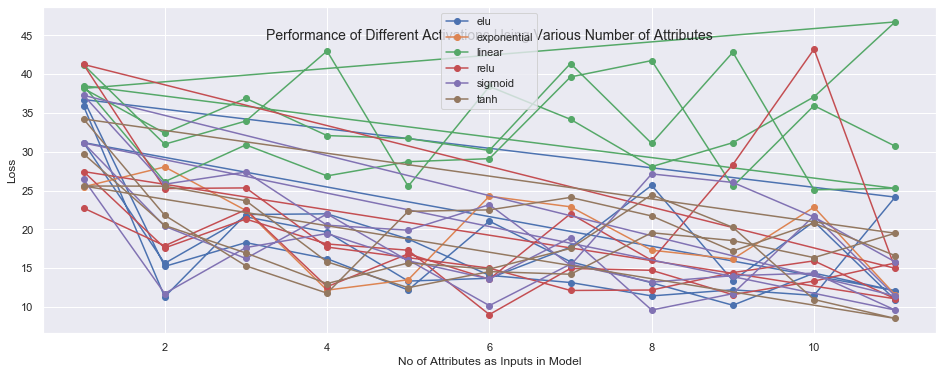

In [38]:
# Plot the actvations to see which performed best
plt.rcParams['figure.figsize'] = [16, 6]
groups = df.groupby('activation')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for activation, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=activation)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Activations Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

Text(0.5, 0.9, 'Performance of Different Optimiser Using Various Number of Attributes')

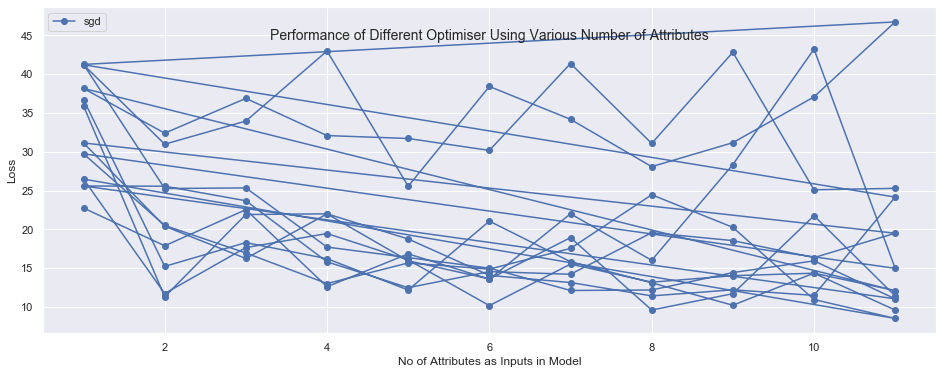

In [32]:
# Plot the actvations to see which performed best
plt.rcParams['figure.figsize'] = [16, 6]
groups = df.groupby('optimiser')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for optimiser, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=optimiser)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Optimiser Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

In [36]:
 df.sort_values(by='loss', ascending=True)

,no_attrib,scaling,test_size,activation,optimiser,no_epochs,batch_size,loss
21,11,True,0.3,tanh,sgd,100,10,8.540646
137,6,True,0.3,relu,adam,100,10,9.040104
32,11,True,0.3,sigmoid,sgd,100,10,9.620605
95,8,True,0.3,sigmoid,sgd,100,10,9.620973
27,6,True,0.3,sigmoid,sgd,100,10,10.194245
118,9,True,0.3,elu,sgd,100,10,10.239728
186,11,True,0.3,elu,adam,100,10,10.932561
20,10,True,0.3,tanh,sgd,100,10,10.976178
76,11,True,0.3,relu,sgd,100,10,11.066633
45,2,True,0.3,elu,sgd,100,10,11.329885
